# Note on analaysis method comparison (25/10/10)

[Purpose of this note]

In this note, Test the three types of analysis methods: 

- Fit: Fit the MI signal with sine wave by picking up a "looks linear" region 

- Zero crossing: Regard one zero crossing section as a half of the wavelength, and interpolate. Use 80% center region (in other words, abandon the start and the end of the scan) 

- Poly fit: Fit the MI signal with sine wave whose phase is nonlinear. Use 80% center region

[Findings]

- If we evalute the linearity of the snom fringe by linewidth of the FFT signal, the zero-crossing method looks narrower linewidth, but maybe due to its lower frequency resolution..

# Analyze the measurement data with three methods

## Import measurement data
Use 0_.npy

In [1]:
from analysis2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

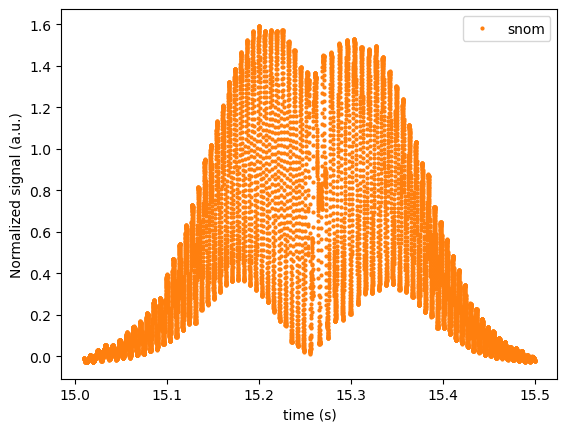

In [24]:
t, snom = load_data("./data/m400_.npy", 0, 0, 50) # filename, CH, start, end
t, mi = load_data("./data/m400_.npy", 2, 0, 50) # filename, CH, start, end

N =15
t_start, t_end = N + 0.01, N + 0.5 # forward
# t_start, t_end = N + 0.2501, N + 0.5 # backward


mask = (t >= t_start) & (t <= t_end)
t_roi, mi_roi, snom_roi = t[mask], mi[mask], snom[mask]
mi_roi = (mi_roi - np.min(mi_roi)) / (np.max(mi_roi) - np.min(mi_roi))
# snom_roi = (snom_roi - np.min(snom_roi)) / (np.max(snom_roi) - np.min(snom_roi))

# plt.plot(t, snom, label="snom", color="tab:orange", marker=".", linestyle="None", markersize=4) # whole plot
plt.plot(t_roi, snom_roi, label="snom", color="tab:orange", marker=".", linestyle="None", markersize=4)
plt.xlabel("time (s)")
plt.ylabel("Normalized signal (a.u.)")
plt.legend()
plt.show()

## Zero crossing: Find linear region and linear interpolate

### Data pick up

In [ ]:
N =10
total_time = 0.25
# percentage_clip = 0.5
# t_center = percentage_clip*total_time
# t_partial = (total_time - t_center)/2
t_start_zc, t_end_zc = N + 0.275, N + 0.475

In [ ]:
mask_zc = (t >= t_start_zc) & (t <= t_end_zc)
t_zc_roi, mi_zc_roi = t[mask_zc], mi[mask_zc]
mi_zc_roi = (mi_zc_roi - np.min(mi_zc_roi)) / (np.max(mi_zc_roi) - np.min(mi_zc_roi))


plt.plot(t_zc_roi, mi_zc_roi, label="mi", color="tab:orange", marker=".", linestyle="None", markersize=4)
plt.xlabel("time (s)")
plt.ylabel("Normalized signal (a.u.)")
plt.legend()
plt.show()

### Find zero point

In [ ]:
zero_indeces = np.where(np.diff(np.sign(mi_zc_roi - 0.5)))[0]
t_zc_zeros = t_zc_roi[zero_indeces]

dist_2 = []
for i in range(len(t_zc_zeros)-1):
    dist_2.append(t_zc_zeros[i+1]-t_zc_zeros[i])

indices_less_than_1e_4 = [i for i, d in enumerate(dist_2) if d < 1e-4]

t_zc_zeros = np.delete(t_zc_zeros, indices_less_than_1e_4)

plt.plot(t_zc_roi, mi_zc_roi )
plt.plot(t_zc_zeros,0.5*np.ones(len(t_zc_zeros)),'.')
plt.xlabel('Time (s)')
plt.ylabel('Norm. MI signal ')


### Find linear region

In [ ]:
dist_2 = []
diff_2 = []
for i in range(len(t_zc_zeros)-1):
    dist_2.append(t_zc_zeros[i+1]-t_zc_zeros[i])

for i in range(len(range(len(dist_2)-1))):
    diff_2.append(dist_2[i+1] - dist_2[i])

plt.plot(dist_2,'-o', label='dist', markersize=3)
plt.plot(diff_2,'-o', label='diff', markersize=3)

upper_bound = 0.00032
lower_bound = -0.00032
plt.axhline(y=upper_bound, color='r', linestyle='-')
plt.axhline(y=lower_bound, color='r', linestyle='-')
plt.axhspan(lower_bound, upper_bound, color='red', alpha=0.1, label='')

plt.xlabel('Index')
plt.ylabel('Time (s)')

plt.legend()

# Find consecutive index in which the two point dist is less than the bound we set
consecutive_indices = []
temp = []

for i in range(len(diff_2)):
    if lower_bound < diff_2[i] < upper_bound:
        temp.append(i)
    else:
        if len(temp) > 1:
            consecutive_indices.append(temp)
        temp = []
consecutive_indices = [seq for seq in consecutive_indices if len(seq) > 5]

# Check if there is a remaining sequence at the end
if len(temp) > 1:
    consecutive_indices.append(temp)

print(consecutive_indices)

In [ ]:

t_start, t_end = t_zc_zeros[consecutive_indices[1][0]], t_zc_zeros[consecutive_indices[1][-1]]

mask_fit = (t >= t_start) & (t <= t_end)
t_fit_roi, mi_fit_roi = t[mask_fit], mi[mask_fit]
mi_fit_roi = (mi_fit_roi - np.min(mi_fit_roi)) / (np.max(mi_fit_roi) - np.min(mi_fit_roi))

plt.plot(t_fit_roi, mi_fit_roi, label="mi", color="tab:orange", marker=".", linestyle="None", markersize=4)
plt.xlabel("time (s)")
plt.ylabel("Normalized signal (a.u.)")
plt.legend()
plt.show()

### Fitting

In [ ]:
def sine_func(t, A, f, phi, offset):
    return A * np.sin(2 * np.pi * f * t + phi) + offset

def fit_sine_phase_swept(t, y, p0, phase_steps=100):
    best_popt = None
    best_pcov = None
    best_residual = np.inf

    initial_phi_values = np.linspace(0, 2 * np.pi, phase_steps)
    for phi in initial_phi_values:
        p0[2] = phi
        try:
            popt, pcov = curve_fit(sine_func, t, y, p0=p0)
            residuals = y - sine_func(t, *popt)
            ss_res = np.sum(residuals**2)
            if ss_res < best_residual:
                best_residual = ss_res
                best_popt = popt
                best_pcov = pcov
        except RuntimeError:
            continue

    return best_popt, best_pcov


In [ ]:
p0 = [0.5, 1/(0.15/20.5), 0, 0.5]  # Initial guess: [Amplitude, Frequency, Phase, Offset]


popt, pcov = fit_sine_phase_swept(t_fit_roi, mi_fit_roi, p0, phase_steps=100)
mi_fit_roi_fit = sine_func(t_fit_roi, *popt)


# --- Plot both in one figure ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]})

# (1) Data + fit
ax1.plot(t_fit_roi, mi_fit_roi, label="Data", color="tab:orange", marker=".", linestyle="None", markersize=4)
ax1.plot(t_fit_roi, mi_fit_roi_fit, label="Fit", color="k", linewidth=1.2)
ax1.set_ylabel("Normalized signal (a.u.)")
ax1.legend()
ax1.set_title("Sine Fit with Nonlinear Phase")

# (2) Residuals
residuals = mi_fit_roi - mi_fit_roi_fit
ss_res = np.sum(residuals**2)

ax2.plot(t_fit_roi, residuals, label="Residuals", color="red", marker=".", linestyle="None", markersize=4)
ax2.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Residual")
ax2.legend()
plt.tight_layout()
plt.show()

# plt.plot(t_fit_roi, mi_fit_roi, label="mi", color="tab:orange", marker=".", linestyle="None", markersize=4)
# plt.plot(t_fit_roi, mi_fit_roi_fit, label="fit", color="k")
# plt.xlabel("time (s)")
# plt.ylabel("Normalized signal (a.u.)")
# plt.legend()
# plt.show()
# residuals = mi_fit_roi - mi_fit_roi_fit
# ss_res = np.sum(residuals**2)
# plt.plot(t_fit_roi, residuals, label="Residuals", color="red", marker=".", linestyle="None", markersize=4)
# plt.xlabel("time (s)")
# plt.ylabel("Residual")
# plt.legend()
# plt.title(f"Sum of squared residuals: {ss_res:.2f}")
# plt.show()



### Time to position

In [ ]:
WL = 1389e-9*1e6 # um
f_opt = popt[1] # /s
dx_dt = WL/2 * f_opt # um/s

mask_zc = (t >= t_start_zc) & (t <= t_end_zc)
t_zc_roi, mi_zc_roi = t[mask_zc], mi[mask_zc]
mi_zc_roi = (mi_zc_roi - np.min(mi_zc_roi)) / (np.max(mi_zc_roi) - np.min(mi_zc_roi))

In [ ]:
x_fit_roi = (t_fit_roi - t_fit_roi[0]) * dx_dt
snom_fit_roi = snom[mask_fit]
snom_fit_roi = (snom_fit_roi - np.min(snom_fit_roi)) / (np.max(snom_fit_roi) - np.min(snom_fit_roi))

plt.plot(x_fit_roi, snom_fit_roi, label="snom", marker = '.')
plt.xlabel("Position (um)")
plt.ylabel("Normalized signal (a.u.)")
# plt.legend()
plt.show()

## Zero-crossing linear interpolate

### Data pick-up

In [ ]:
t, snom = load_data("./data/0_.npy", 0, 0, 50) # filename, CH, start, end
t, mi = load_data("./data/0_.npy", 2, 0, 50) # filename, CH, start, end

total_time = 0.25
percentage_clip = 0.5
N = 10

t_center = percentage_clip*total_time
t_partial = (total_time - t_center)/2
t_start_zc, t_end_zc = N + t_partial, N + total_time - t_partial 

mask_zc = (t >= t_start_zc) & (t <= t_end_zc)
t_zc_roi, mi_zc_roi = t[mask_zc], mi[mask_zc]
mi_zc_roi = (mi_zc_roi - np.min(mi_zc_roi)) / (np.max(mi_zc_roi) - np.min(mi_zc_roi))


### Find zero-crossing points

In [ ]:
zero_indeces = np.where(np.diff(np.sign(mi_zc_roi - 0.5)))[0]
t_zc_zeros = t_zc_roi[zero_indeces]

dist_2 = []
for i in range(len(t_zc_zeros)-1):
    dist_2.append(t_zc_zeros[i+1]-t_zc_zeros[i])

indices_less_than_1e_4 = [i for i, d in enumerate(dist_2) if d < 1e-4]

t_zc_zeros = np.delete(t_zc_zeros, indices_less_than_1e_4)

plt.plot(t_zc_roi, mi_zc_roi )
plt.plot(t_zc_zeros, 0.5*np.ones(len(t_zc_zeros)),'.')

### Time to position

In [ ]:
WL = 1389e-9*1e6 # um
wl_ref = np.arange(len(t_zc_zeros))
x_zc_roi = WL/4 * np.interp(t_zc_roi, t_zc_zeros, wl_ref)

In [ ]:
snom_zc_roi = snom[mask_zc]
snom_zc_roi = (snom_zc_roi - np.min(snom_zc_roi)) / (np.max(snom_zc_roi) - np.min(snom_zc_roi))

plt.plot(x_zc_roi, snom_zc_roi, '.', markersize = 1)
plt.xlabel("Position (um)")
plt.ylabel("Normalized signal (a.u.)")
# plt.legend()
plt.show()

## Poly fit: fit by polynomial

### Data pick up

In [ ]:
t, snom = load_data("./data/0_.npy", 0, 0, 50) # filename, CH, start, end
t, mi = load_data("./data/0_.npy", 2, 0, 50) # filename, CH, start, end
N = 10 # sample number

total_time = 0.25
percentage_clip = 0.8
t_center = percentage_clip*total_time
time_section = t_center/3
t_partial = (total_time - t_center)/2
t_start_pol, t_end_pol = N + t_partial, N + time_section 

In [ ]:
mask_pol = (t >= t_start_pol) & (t <= t_end_pol)
t_pol_roi, mi_pol_roi,snom_pol_roi= t[mask_pol], mi[mask_pol],snom[mask_pol]
mi_pol_roi = (mi_pol_roi - np.min(mi_pol_roi)) / (np.max(mi_pol_roi) - np.min(mi_pol_roi))

snom_pol_roi_norm = (snom_pol_roi - np.min(snom_pol_roi)) / (np.max(snom_pol_roi) - np.min(snom_pol_roi))

plt.plot(t_pol_roi, mi_pol_roi, label="mi", color="tab:orange", marker=".", linestyle="None", markersize=4)
plt.xlabel("time (s)")
plt.ylabel("Normalized MI signal (a.u.)")
plt.show()

### Fitting


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# t_pol_roi (time) and mi_pol_roi (signal) must be defined 1D arrays

# ---- quick FFT freq guess (robust to uneven sampling via resampling) ----
def f_guess(x, y):
    n = min(4096, max(256, 2**int(np.ceil(np.log2(len(x))))))
    xu = np.linspace(x.min(), x.max(), n)
    yu = np.interp(xu, x, y - np.median(y))
    dt = np.median(np.diff(xu))
    Y = np.fft.rfft(yu)
    f = np.fft.rfftfreq(len(yu), d=dt)
    if len(f) <= 2:
        return 1.0 / max(x.max()-x.min(), 1.0)
    k = 1 + np.argmax(np.abs(Y[1:]))  # ignore DC
    return max(float(f[k]), 1e-9)

# ---- model factory: captures m and x0 cleanly ----
def make_model(m, x0):
    def model(x, A, f, phi0, *c_and_offset):
        c = c_and_offset[:-1]; off = c_and_offset[-1]
        xt = x - x0
        if m > 0:
            # P = Σ_{k=1..m} c_k xt^k ; build via Vandermonde
            P = np.vander(xt, N=m+1, increasing=True)[:, 1:] @ np.asarray(c)
        else:
            P = 0.0
        return off + A * np.sin(2*np.pi*f*xt + phi0 + P)
    return model

# ---- instantaneous frequency from fitted params ----
def finst_from_params(xq, m, x0, f_hz, c):
    xt = xq - x0
    dphi_dx = 2*np.pi*f_hz
    if m > 0 and len(c) == m:
        V = np.vander(xt, N=m, increasing=True)          # xt^0..xt^{m-1}
        kc = np.arange(1, m+1) * np.asarray(c)           # k*c_k
        dphi_dx = dphi_dx + V @ kc
    return dphi_dx / (2*np.pi)

# ---- sweep small phase orders and pick the best ----
x = np.asarray(t_pol_roi, float).ravel()
y = np.asarray(mi_pol_roi, float).ravel()
x0 = x.mean()

A0 = 0.5*(np.nanpercentile(y, 95) - np.nanpercentile(y, 5))
f0 = f_guess(x, y)
m_values = range(15)   # keep small to avoid overfit/instability

results = []              # will hold dicts per m
Res_array = []            # SSE per m for selection

for m in m_values:
    model = make_model(m, x0)
    p0 = [A0, f0, 0.0] + [0.0]*m + [np.median(y)]             # [A,f,phi0,c1..cm,off]
    lb = [0.0, 1e-9, -np.inf] + [-np.inf]*m + [-np.inf]
    ub = [np.inf,  np.inf,  np.inf] + [ np.inf]*m + [ np.inf]
    try:
        popt, pcov = curve_fit(model, x, y, p0=p0, bounds=(lb, ub), maxfev=20000)
        yhat = model(x, *popt)
        ss_res = float(np.sum((y - yhat)**2))
        Res_array.append(ss_res)
        results.append({"m": m, "popt": popt, "pcov": pcov, "ss_res": ss_res})
    except Exception:
        Res_array.append(np.inf)
        results.append({"m": m, "popt": None, "pcov": None, "ss_res": np.inf})

plt.figure(figsize=(10, 6))
plt.plot(m_values, Res_array, 'o-', label='SSE vs Degrees', color='b')
plt.xlabel('Degrees (m)')
plt.ylabel('Sum of Squares of Residuals (SSE)')
plt.title('SSE for Different Polynomial Degrees')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# ---- choose best order ----
best_idx = int(np.argmin(Res_array))
best = results[best_idx]
m_best = best["m"]
popt = best["popt"]
assert popt is not None, "All fits failed; consider smoothing data or narrowing m_values."

# ---- unpack best params ----
A, f_hz, phi0 = popt[0], popt[1], popt[2]
c = popt[3:3+m_best] if m_best > 0 else []
offset = popt[-1]

# ---- smooth line + instantaneous frequency ----
xd = np.linspace(x.min(), x.max(), 2000)
model_best = make_model(m_best, x0)
yd = model_best(xd, *popt)
res = y - model_best(x, *popt)
f_inst = finst_from_params(xd, m_best, x0, f_hz, c)

print(f"Best order m = {m_best}  |  SSE = {best['ss_res']:.6g}")
print(f"A={A:.6g}, f={f_hz:.6g} Hz, phi0={phi0:.6g}, offset={offset:.6g}")
for i, ck in enumerate(c, 1):
    print(f"c{i}={ck:.6g}")

# ---- (optional) plots: data+fit, residuals, instantaneous frequency ----
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1.2, 1.8], hspace=0.22)
ax1 = fig.add_subplot(gs[0,0]); ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax1.plot(x, y, '.', ms=3, label='Data')
ax1.plot(xd, yd, '-', lw=0.5, label=f'Fit (m={m_best})',color='k')
ax1.set_ylabel('MI signal (a.u.)')
ax1.set_title(f"Sample # {N}")
ax1.legend()

ax2.plot(x, res, '.', ms=3, label='Residuals', color='C3')
ax2.axhline(0, ls='--', lw=0.8, color='k')
ax2.set_ylabel('Residual')
# ax2.legend()
# ax2.set_title(f"SSE = {best['ss_res']:.3g}")

plt.tight_layout(); plt.show()

In [ ]:
import numpy as np

# inputs from your fit
t_ = t_pol_roi.astype(float)
t0 = t_.mean()
A, f, phi0 = popt[0], popt[1], popt[2]
m = len(popt) - 4                     # number of phase poly terms
c = np.asarray(popt[3:3+m]) if m>0 else np.array([])
offset = popt[-1]

# constants
lam = 1.389e-6     # 1389 nm
n = 1.0           # ~1.00027 in air if you want to be precise

tt = t_ - t0
# phase(t):
phi = 2*np.pi*f*tt + phi0 + (np.vander(tt, N=m+1, increasing=True)[:,1:] @ c if m>0 else 0.0)

# choose reference so x(t0)=0 => subtract phi0
x = (lam/(4*np.pi*n)) * (phi - phi0)          # position (meters)
x_lin = x - x[0]
# instantaneous frequency and velocity
# dphi/dt = 2π f + Σ k c_k (t-t0)^{k-1}
if m>0:
    V = np.vander(tt, N=m, increasing=True)   # columns: tt^0 .. tt^{m-1}
    kc = (np.arange(1, m+1) * c)              # k * c_k
    dphi_dt = 2*np.pi*f + V @ kc
else:
    dphi_dt = 2*np.pi*f * np.ones_like(tt)

f_inst = dphi_dt / (2*np.pi)                  # Hz
v = (lam/(2*n)) * f_inst                      # m/s


In [ ]:
# plot SNOM signal
plt.figure()
plt.plot(x_lin*1e6,snom_pol_roi_norm)
plt.xlabel('Position (um)')
plt.ylabel('Norm. SNOM signal')



## Envelop sine fit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --------- helpers ---------
def _freq_guess(x, y):
    # FFT-based spatial frequency guess (resample to uniform grid)
    n = min(4096, max(512, 2**int(np.ceil(np.log2(len(x))))))
    xu = np.linspace(x.min(), x.max(), n)
    yu = np.interp(xu, x, y - np.median(y))
    dx = np.median(np.diff(xu))
    Y = np.fft.rfft(yu); f = np.fft.rfftfreq(n, d=dx)
    k = 1 + np.argmax(np.abs(Y[1:])) if len(f) > 2 else 1
    return max(float(f[k]), 1e-12)  # cycles per x-unit

# --------- models: A(x) * (sin(2π k x + φ0) + c) ---------
def make_model_gaussian():
    # params: [A0, mu, sigma, k, phi0, c]
    def model(x, A0, mu, sigma, k, phi0, c):
        x = np.asarray(x, float)
        env = A0 * np.exp(-0.5 * ((x - mu) / np.abs(sigma))**2)
        return env * (np.sin(2*np.pi*k*x + phi0) + c)
    return model

def make_model_poly(deg=2):
    # params: [A0, a1..adeg, k, phi0, c], with x centered at x0
    def model(x, *p):
        x = np.asarray(x, float); x0 = x.mean()
        A0 = p[0]
        a  = np.asarray(p[1:1+deg]) if deg>0 else np.array([])
        k  = p[1+deg]; phi0 = p[2+deg]; c = p[3+deg]
        tt = x - x0
        env = A0 * (1.0 + (np.vander(tt, N=deg+1, increasing=True)[:,1:] @ a if deg>0 else 0.0))
        # Optional safety to avoid negative envelope:
        # env = np.maximum(env, 1e-12)
        return env * (np.sin(2*np.pi*k*x + phi0) + c)
    return model

# --------- fitter ---------
def fit_A_times_sin_plus_c(x, y, envelope="gaussian", deg=2, maxfev=50000):
    x = np.asarray(x, float).ravel()
    y = np.asarray(y, float).ravel()
    A0 = 0.5*(np.percentile(y,95) - np.percentile(y,5))
    k0 = _freq_guess(x, y)
    phi0 = 0.0
    c0 = 0.0  # you can try np.clip(np.mean(y)/max(A0,1e-12), -0.9, 0.9)

    if envelope == "gaussian":
        model = make_model_gaussian()
        mu0 = float(x[np.argmax(y)]) if np.isfinite(y).all() else x.mean()
        sigma0 = 0.25*(x.max()-x.min())
        p0 = [A0, mu0, sigma0, k0, phi0, c0]
        lb = [0.0, x.min(), 1e-12, 1e-12, -np.inf, -1.0]
        ub = [np.inf, x.max(),  np.inf,  np.inf,  np.inf,  1.0]
    else:
        model = make_model_poly(deg=deg)
        p0 = [A0] + [0.0]*deg + [k0, phi0, c0]
        lb = [0.0] + [-np.inf]*deg + [1e-12, -np.inf, -1.0]
        ub = [np.inf] + [ np.inf]*deg + [ np.inf,  np.inf,  1.0]

    popt, pcov = curve_fit(model, x, y, p0=p0, bounds=(lb, ub), maxfev=maxfev)
    yhat = model(x, *popt)
    resid = y - yhat
    rmse = float(np.sqrt(np.mean(resid**2)))
    return model, popt, pcov, yhat, resid, rmse

# --------- example usage ---------
# x_data = x_lin*1e6  # your position (e.g., µm)
# y_data = snom_pol_roi_norm   # your normalized SNOM signal

# x_data, y_data = x_fit_roi, snom_fit_roi
x_data, y_data = x_zc_roi[10:-60], snom_zc_roi[10:-60]

# Choose ONE:
model, popt, pcov, yhat, resid, rmse = fit_A_times_sin_plus_c(x_data, y_data, envelope="gaussian")
# or:
# model, popt, pcov, yhat, resid, rmse = fit_A_times_sin_plus_c(x_data, y_data, envelope="poly", deg=5)
# Plot
xx = np.linspace(x_data.min(), x_data.max(), 2000)
yy = model(xx, *popt)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,6), sharex=True, gridspec_kw={'height_ratios':[3,1.2]})
ax1.plot(x_data, y_data, '.', ms=3, label='Data')
ax1.plot(xx, yy, '-', lw=0.8, label='Fit', color='k')
ax1.set_ylabel('Norm. SNOM signal'); ax1.legend()
ax1.set_title('Fit: A(x) * (sin(2π k x + φ0) + c)')
ax2.plot(x_data, y_data - yhat, '.', ms=3, color='C3', label='Residuals')
ax2.axhline(0, color='k', lw=0.8, ls='--'); ax2.set_xlabel('Position (um)'); ax2.set_ylabel('Residual'); ax2.legend()
plt.tight_layout(); plt.show()
print('RMSE:', rmse); print('popt:', popt); print('Propagation const:', popt[-3], ' /um')


# Evaluate the linearity of snom signals

In [ ]:
# ## fit
# N_fit = len(snom_fit_roi)
# fx_fit = 1 / (x_fit_roi[1] - x_fit_roi[0])
# X_fit = np.fft.fft(snom_fit_roi)
# freq_fit = np.fft.fftfreq(N_fit, d=1/fx_fit)
# amp_fit = np.abs(X_fit) / N_fit * 2

## zero crossing
N_zc = len(snom_zc_roi)
x_zc_uniform = np.linspace(x_zc_roi.min(), x_zc_roi.max(), N_zc)
fz_zc = 1 / (x_zc_uniform[1] - x_zc_uniform[0])
snom_zc_uniform = np.interp(x_zc_uniform, x_zc_roi, snom_zc_roi)
Y = np.fft.fft(snom_zc_uniform)
freq_zc = np.fft.fftfreq(N_zc, d=(x_zc_uniform[1] - x_zc_uniform[0]))

## plot
# plt.plot(freq_fit[:N_fit//2], amp_fit[:N_fit//2], label="fit", color="r")
plt.plot(freq_zc[:N_zc//2], np.abs(Y)[:N_zc//2] / N_zc * 2, label="zero crossing", color="b")
plt.xlim(0, 2)
plt.xlabel("Frequency (1/um)")
plt.ylabel("Amplitude (a.u.)")
plt.legend()
plt.show()

max_index = np.argmax(np.abs(Y)[1:N_zc//2] / N_zc * 2)
max_frequency = freq_zc[max_index]
max_frequency




In [ ]:
mag = np.abs(Y) / N_zc * 2            # single-sided magnitude scaling (if you used rfft, adapt)
# Focus on positive frequencies (exclude DC bin 0)
N_half = min(len(freq_zc), len(mag)) // 2
f_pos  = freq_zc[1:N_half]            # start from index 1 to skip DC
m_pos  = mag[1:N_half]

# ---- Exclude the DC wall by thresholding low freqs ----
fmin = 0.25                           # set your cutoff (units same as freq_zc)
mask = f_pos >= fmin                  # ignore everything below fmin
if not np.any(mask):
    raise ValueError("No bins remain above fmin; lower fmin or check freq axis.")

f_sel = f_pos[mask]
m_sel = m_pos[mask]

# ---- Find the peak ----
k = int(np.argmax(m_sel))
f_peak = float(f_sel[k])
amp_peak = float(m_sel[k])

print("Peak frequency (excluding DC):", f_peak)

# Test

### Three different analysis method

In [ ]:
# Fit with linear sine
from Data_analysis import DataAnalysis
import numpy as np

filename = "./data/0_.npy"
beta1_array = []
beta1_err_array = []

beta2_array = []
beta2_err_array = []

beta3_array = []
beta3_err_array = []


for N in range(10,50):
    print(N)
    # linear method
    analysis = DataAnalysis(filename, N)
    analysis.linear_method()
    if hasattr(analysis, 'x_linear'):
        xx1, yy1, beta1, beta1_err = analysis.EnvSin_fit(1,0) # for linear fit, polynomial envelop is better
        beta1_array.append(beta1)
        beta1_err_array.append(beta1_err)

    # linear iterpolate method
    analysis.zero_crossing_interpol()
    xx2, yy2, beta2, beta2_err = analysis.EnvSin_fit(0,1)
    beta2_array.append(beta2)
    beta2_err_array.append(beta2_err)

    # nonlinear method
    analysis.nonlinear_method()
    xx3, yy3, beta3, beta3_err = analysis.EnvSin_fit(0,2)
    beta3_array.append(beta3)
    beta3_err_array.append(beta3_err)



In [ ]:
# remove None in the lists
beta1_array = [b for b in beta1_array if b is not None]
beta2_array = [b for b in beta2_array if b is not None]
beta3_array = [b for b in beta3_array if b is not None]

beta1_error_array = [b for b in beta1_err_array if b is not None]
beta2_error_array = [b for b in beta2_err_array if b is not None]
beta3_error_array = [b for b in beta3_err_array if b is not None]

# Calculate weighted mean and SME
Mw1, SMEw1 = analysis.weighted_cal(beta1_array, beta1_error_array)
Mw2, SMEw2 = analysis.weighted_cal(beta2_array, beta2_error_array)
Mw3, SMEw3 = analysis.weighted_cal(beta3_array, beta3_error_array)

# Convert them into pitch
pitch1 = np.pi/Mw1*1e-6 # m
pitch1_err = np.pi/Mw1**2*SMEw1*1e-6 # m

pitch2 = np.pi/Mw2*1e-6 # m
pitch2_err = np.pi/Mw2**2*SMEw2*1e-6 # m

pitch3 = np.pi/Mw3*1e-6 # m
pitch3_err = np.pi/Mw3**2*SMEw3*1e-6 # m

print('Linear fit gives pitch', pitch1*1e9, '+-', pitch1_err*1e9, 'nm')
print('Linear interpolation fit gives', pitch2*1e9, '+-', pitch2_err*1e9, 'nm')
print('Nonlinear fit give pitch', pitch3*1e9, '+-', pitch3_err*1e9, 'nm')

In [ ]:
# from beta_vs_radius_plot__ import CompactFiberSolver
# from Data_analysis import DataAnalysis


# # diameter calculation
# d1, d1_err = analysis.diamter_calculation(pitch1, pitch1_err)

# d2, d2_err = analysis.diamter_calculation(pitch2, pitch2_err)

# d3, d3_err = analysis.diamter_calculation(pitch3, pitch3_err)

# print('Linear fit gives diameter', d1*1e9, '+-', d1_err*1e9, 'nm')
# print('Linear interpolation fit gives diameter', d2*1e9, '+-', d2_err*1e9, 'nm')
# print('Nonlinear fit gives diameter ', d3*1e9, '+-', d3_err*1e9, 'nm')

In [ ]:
from Data_analysis import DataAnalysis
import numpy as np
from scipy.interpolate import interp1d

filename = "./data/0_.npy"
analysis = DataAnalysis(filename, N=10)

# Find 20 points of pitch to diameter calculation
pitch_sweep = np.linspace(0.69, 0.64, 20) # um
dia_sweep = []

 
for i in range(len(pitch_sweep)):
    d0_, d0_err_ = analysis.diamter_calculation(pitch_sweep[i]*1e-6, 0)
    dia_sweep.append(d0_)

In [ ]:
import matplotlib.pyplot as plt
# Interpolate dia_sweep and pitch_sweep

# Ensure there are no missing values in dia_sweep
# dia_sweep = np.array(dia_sweep)
# dia_sweep = [d for d in dia_sweep if d is not None]

# # Create interpolation function
# interpolation_func = interp1d(pitch_sweep, dia_sweep, kind='linear', fill_value='extrapolate')

# # Define new pitch values for interpolation
# pitch_values = np.linspace(min(pitch_sweep), max(pitch_sweep), 10000) # 100 points for better resolution

# # Interpolated diameter values
# interpolated_dia_values = interpolation_func(pitch_values)

#  load diameter pitch profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

plt.figure(figsize=(10, 6))
plt.plot(pitch_values, interpolated_dia_values, label='Interpolated Diameter', color='b', marker='o')
plt.xlabel('Pitch (um)')
plt.ylabel('Diameter (arbitrary units)')
plt.title('Interpolated Diameter vs. Pitch')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np
# Convert beta arrays and errors into numpy arrays and clean them
beta1_array = np.asarray(beta1_array, float)
beta2_array = np.asarray(beta2_array, float)
beta3_array = np.asarray(beta3_array, float)

beta1_err_array = np.asarray(beta1_err_array, float)
beta2_err_array = np.asarray(beta2_err_array, float)
beta3_err_array = np.asarray(beta3_err_array, float)

# Ensure they are calculatable by filtering valid values
beta1_array = beta1_array[np.isfinite(beta1_array)]
beta2_array = beta2_array[np.isfinite(beta2_array)]
beta3_array = beta3_array[np.isfinite(beta3_array)]

beta1_err_array = beta1_err_array[np.isfinite(beta1_err_array)]
beta2_err_array = beta2_err_array[np.isfinite(beta2_err_array)]
beta3_err_array = beta3_err_array[np.isfinite(beta3_err_array)]

pitch1_array = np.pi/beta1_array*1e-6 # m
pitch1_err_array = np.pi/beta1_array**2*beta1_err_array*1e-6

pitch2_array = np.pi/beta2_array*1e-6 # m
pitch2_err_array = np.pi/beta2_array**2*beta2_err_array*1e-6

pitch3_array = np.pi/beta3_array*1e-6 # m
pitch3_err_array = np.pi/beta3_array**2*beta3_err_array*1e-6

# --- ensure units match ---
# Your pitch1/2/3_array are in meters; convert reference to meters too
pitch_values_m = np.asarray(pitch_values, float) * 1e-6
dia_vals = np.asarray(interpolated_dia_values, float)

if pitch_values_m.shape != dia_vals.shape:
    raise ValueError("pitch_values and interpolated_dia_values must have the same shape.")

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# ---- use it (no loops) ----
d1_array, idx1 = nearest_diameter_from_pitch(pitch1_array, pitch_values_m, dia_vals)
d2_array, idx2 = nearest_diameter_from_pitch(pitch2_array, pitch_values_m, dia_vals)
d3_array, idx3 = nearest_diameter_from_pitch(pitch3_array, pitch_values_m, dia_vals)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Scale to nm
d1 = np.asarray(d1_array, float) * 1e9
d2 = np.asarray(d2_array, float) * 1e9
d3 = np.asarray(d3_array, float) * 1e9

# Consistent bins across all three
all_vals = np.concatenate([d1, d2, d3])
bins = np.histogram_bin_edges(all_vals, bins=30)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

axes[0].hist(d1, bins=bins, alpha=0.3, edgecolor='black', color = 'blue', label='Linear fit method')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(d2, bins=bins, alpha=0.3, edgecolor='black', color='red', label='Linear interpol fit method')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)
axes[1].legend()


axes[2].hist(d3, bins=bins, alpha=0.3, edgecolor='black', color='green',label='nonlinera fit method' )
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Diameter (nm)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()


# Squeeze vertical spacing a bit
plt.tight_layout()
plt.subplots_adjust(hspace=0.12)

plt.show()


In [ ]:
mean_d1 = np.mean(d1)
mean_d2 = np.mean(d2)
mean_d3 = np.mean(d3)

std_d1 = np.std(d1)
std_d2 = np.std(d2)
std_d3 = np.std(d3)
print(mean_d1)
print(mean_d2)
print(mean_d3)
print("Standard Deviation of d1:", std_d1)
print("Standard Deviation of d2:", std_d2)
print("Standard Deviation of d3:", std_d3)


### Three sections with the second method

In [ ]:
# Fit with linear sine
from Data_analysis import DataAnalysis
import numpy as np

filename = "./data/0_.npy"
beta1_array = []

beta2_array = []

beta3_array = []


for N in np.arange(10, 50, 0.5):
    print(N)

    analysis = DataAnalysis(filename, N)

    # linear iterpolate method
    xx1, yy1, xx2, yy2, xx3, yy3 = analysis.zero_crossing_interpol_by_section()

    # section 1
    xx_1, yy_1, beta_1, beta_1_err = analysis.EnvSin_fit_section_by_section(1,xx1,yy1)
    beta1_array.append(beta_1)

    # section 2
    xx_2, yy_2, beta_2, beta_2_err = analysis.EnvSin_fit_section_by_section(1,xx2,yy2)
    beta2_array.append(beta_2)

    # section 3
    xx_3, yy_3, beta_3, beta_3_err = analysis.EnvSin_fit_section_by_section(1,xx3,yy3)
    beta3_array.append(beta_3)


In [ ]:
import numpy as np

#  load diameter pitch profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

# Convert beta arrays and errors into numpy arrays and clean them
beta1_array = np.asarray(beta1_array, float)
beta2_array = np.asarray(beta2_array, float)
beta3_array = np.asarray(beta3_array, float)

# Ensure they are calculatable by filtering valid values
beta1_array = beta1_array[np.isfinite(beta1_array)]
beta2_array = beta2_array[np.isfinite(beta2_array)]
beta3_array = beta3_array[np.isfinite(beta3_array)]

pitch1_array = np.pi/beta1_array*1e-6 # m

pitch2_array = np.pi/beta2_array*1e-6 # m

pitch3_array = np.pi/beta3_array*1e-6 # m

# --- ensure units match ---
# Your pitch1/2/3_array are in meters; convert reference to meters too
pitch_values_m = np.asarray(pitch_values, float) * 1e-6
dia_vals = np.asarray(interpolated_dia_values, float)

if pitch_values_m.shape != dia_vals.shape:
    raise ValueError("pitch_values and interpolated_dia_values must have the same shape.")

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# ---- use it (no loops) ----
d1_array, idx1 = nearest_diameter_from_pitch(pitch1_array, pitch_values_m, dia_vals)
d2_array, idx2 = nearest_diameter_from_pitch(pitch2_array, pitch_values_m, dia_vals)
d3_array, idx3 = nearest_diameter_from_pitch(pitch3_array, pitch_values_m, dia_vals)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Scale to nm
d1 = np.asarray(d1_array, float) * 1e9
d2 = np.asarray(d2_array, float) * 1e9
d3 = np.asarray(d3_array, float) * 1e9

# Consistent bins across all three
all_vals = np.concatenate([d1, d2, d3])
bins = np.histogram_bin_edges(all_vals, bins=30)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

axes[0].hist(d1, bins=bins, alpha=0.3, edgecolor='black', color = 'blue', label='section 1')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(d2, bins=bins, alpha=0.3, edgecolor='black', color='red', label='sectionn 2')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)
axes[1].legend()


axes[2].hist(d3, bins=bins, alpha=0.3, edgecolor='black', color='green',label='section 3' )
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Diameter (nm)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()


# Squeeze vertical spacing a bit
plt.tight_layout()
plt.subplots_adjust(hspace=0.12)

plt.show()


### Three sections with method 3

In [ ]:
# Fit with linear sine
from Data_analysis import DataAnalysis
import numpy as np

filename = "./data/0_.npy"
beta1_array = []

beta2_array = []

beta3_array = []


for N in np.arange(10,50,0.5):
    print(N)

    analysis = DataAnalysis(filename, N)

    # linear iterpolate method
    xx1, yy1, xx2, yy2, xx3, yy3 = analysis.nonlinear_method_by_section()

    # section 1
    xx_1, yy_1, beta_1, beta_1_err = analysis.EnvSin_fit_section_by_section(1,xx1,yy1)
    beta1_array.append(beta_1)

    # section 2
    xx_2, yy_2, beta_2, beta_2_err = analysis.EnvSin_fit_section_by_section(1,xx2,yy2)
    beta2_array.append(beta_2)

    # section 3
    xx_3, yy_3, beta_3, beta_3_err = analysis.EnvSin_fit_section_by_section(1,xx3,yy3)
    beta3_array.append(beta_3)


In [ ]:
# Load pitch diameter profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

import numpy as np
# Convert beta arrays and errors into numpy arrays and clean them
beta1_array = np.asarray(beta1_array, float)
beta2_array = np.asarray(beta2_array, float)
beta3_array = np.asarray(beta3_array, float)

# Ensure they are calculatable by filtering valid values
beta1_array = beta1_array[np.isfinite(beta1_array)]
beta2_array = beta2_array[np.isfinite(beta2_array)]
beta3_array = beta3_array[np.isfinite(beta3_array)]

pitch1_array = np.pi/beta1_array*1e-6 # m

pitch2_array = np.pi/beta2_array*1e-6 # m

pitch3_array = np.pi/beta3_array*1e-6 # m

# --- ensure units match ---
# Your pitch1/2/3_array are in meters; convert reference to meters too
pitch_values_m = np.asarray(pitch_values, float) * 1e-6
dia_vals = np.asarray(interpolated_dia_values, float)

if pitch_values_m.shape != dia_vals.shape:
    raise ValueError("pitch_values and interpolated_dia_values must have the same shape.")

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# ---- use it (no loops) ----
d1_array, idx1 = nearest_diameter_from_pitch(pitch1_array, pitch_values_m, dia_vals)
d2_array, idx2 = nearest_diameter_from_pitch(pitch2_array, pitch_values_m, dia_vals)
d3_array, idx3 = nearest_diameter_from_pitch(pitch3_array, pitch_values_m, dia_vals)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Scale to nm
d1 = np.asarray(d1_array, float) * 1e9
d2 = np.asarray(d2_array, float) * 1e9
d3 = np.asarray(d3_array, float) * 1e9

# Consistent bins across all three
all_vals = np.concatenate([d1, d2, d3])
bins = np.histogram_bin_edges(all_vals, bins=30)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

axes[0].hist(d1, bins=bins, alpha=0.3, edgecolor='black', color = 'blue', label='section 1')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(d2, bins=bins, alpha=0.3, edgecolor='black', color='red', label='sectionn 2')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)
axes[1].legend()


axes[2].hist(d3, bins=bins, alpha=0.3, edgecolor='black', color='green',label='section 3' )
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Diameter (nm)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()


# Squeeze vertical spacing a bit
plt.tight_layout()
plt.subplots_adjust(hspace=0.12)

plt.show()


### Find phase ratio of SNOM and MI signal

In [ ]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Load pitch diameter profile
# data = np.load('./diameter_pitch_profile.npz')
# pitch_values = data['pitch_values']
# interpolated_dia_values = data['interpolated_dia_values']

pitch_values_m = np.asarray(pitch_values, float) * 1e-6
dia_vals = np.asarray(interpolated_dia_values, float)

# Define the sine wave function for fitting
def sine_wave(t, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset
def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx
WL = 1.389 # um

# Load data
t, snom = load_data("./data/0_.npy", 0, 0, 50) # filename, CH, start, end
t, mi = load_data("./data/0_.npy", 2, 0, 50) # filename, CH, start, end

N =10
t_start_phi, t_end_phi = N + 0.025, N + 0.225

mask_phi_ratio = (t >= t_start_phi) & (t <= t_end_phi)
t_phi_ratio, mi_phi_ratio, snom_phi_ratio = t[mask_phi_ratio], mi[mask_phi_ratio], snom[mask_phi_ratio]

# Find peaks on snom_phi_ratio and their indices
peaks, _ = find_peaks(-snom_phi_ratio,prominence=0.05)

# Find peak value and index
peak_values = snom_phi_ratio[peaks]

# Find corresponding time using t_phi_ratio at the identified indices
corresponding_times = t_phi_ratio[peaks]
filtered_indices = np.where(np.diff(corresponding_times) >= 0.004)[0]
corresponding_times = corresponding_times[filtered_indices]
peak_values = peak_values[filtered_indices]

beta_ = []
# Find the correspoinding MI signal
for kiwi in range(len(corresponding_times)-1):
    mask_period = (t >= corresponding_times[kiwi]) & (t <= corresponding_times[kiwi+1])
    t_period, mi_period, snom_period = t[mask_period], mi[mask_period], snom[mask_period]
    mi_period = (mi_period - np.min(mi_period)) / (np.max(mi_period) - np.min(mi_period))
    snom_period = (snom_period - np.min(snom_period)) / (np.max(snom_period) - np.min(snom_period))

    MI_i = mi_period[0]
    MI_f = mi_period[-1]
    # Find 0.5 crossing points
    crossing_points = []

    # Iterate through mi_period to find points where it crosses 0.5
    for i in range(len(mi_period) - 1):
        if (mi_period[i] < 0.5 and mi_period[i + 1] >= 0.5) or (mi_period[i] > 0.5 and mi_period[i + 1] <= 0.5):
            # Linear interpolation to find the exact crossing point
            t_cross = t_period[i] + (0.5 - mi_period[i]) * (t_period[i + 1] - t_period[i]) / (mi_period[i + 1] - mi_period[i])
            crossing_points.append(t_cross)
        
    phi_pi = crossing_points[-1] - crossing_points[0]
    phi = np.pi*(t_period[-1] -t_period[-0])/phi_pi

    if 0:
        fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

        # Plot snom_period and its fit
        ax1.plot(t_period, snom_period, label='Snom Period', color='blue')
        ax1.plot(t_period, sine_wave(t_period, *params_snom), label='Fit Snom', linestyle='--', color='red')
        ax1.set_title('Snom Period and Fit')
        ax1.legend()
        ax1.grid(True)

        # Plot mi_period and its fit
        ax3.plot(t_period, mi_period, label='MI Period', color='blue')
        ax3.plot(t_period, sine_wave(t_period, *params_mi), label='Fit MI', linestyle='--', color='red')
        ax3.set_title('MI Period and Fit')
        ax3.legend()
        ax3.grid(True)


        plt.tight_layout()
        plt.show()

    # find the n_eff and beta
    n_eff = 2*np.pi/phi
    beta = 2*np.pi*n_eff/WL
    beta_.append(beta)

# Convert beta arrays and errors into numpy arrays and clean them
beta_ = np.asarray(beta_, float)

beta_ = beta_[beta_ >= 0.1]

pitch_ = np.pi/beta_*1e-6 # m

d1_, idx1 = nearest_diameter_from_pitch(pitch_, pitch_values_m, dia_vals)
d1 = np.asarray(d1_, float) * 1e9


plt.figure()
mean_diameter = np.mean(d1)
plt.axvline(mean_diameter, color='red', linestyle='dashed', linewidth=1, label='Mean Diameter')
plt.hist(d1, bins=20, alpha=0.3, edgecolor='black', color = 'blue', label='Rising edge')
plt.xlabel('Diameter (nm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

In [ ]:
# falling edge
t_start_phi, t_end_phi = N + 0.275, N + 0.475

mask_phi_ratio = (t >= t_start_phi) & (t <= t_end_phi)
t_phi_ratio, mi_phi_ratio, snom_phi_ratio = t[mask_phi_ratio], mi[mask_phi_ratio], snom[mask_phi_ratio]

# Find peaks on snom_phi_ratio and their indices
peaks, _ = find_peaks(snom_phi_ratio,prominence=0.1)

# Find peak value and index
peak_values = snom_phi_ratio[peaks]

# Find corresponding time using t_phi_ratio at the identified indices
corresponding_times = t_phi_ratio[peaks]
filtered_indices = np.where(np.diff(corresponding_times) >= 0.004)[0]
corresponding_times = corresponding_times[filtered_indices]
peak_values = peak_values[filtered_indices]



# find phase in each period
# time_differences = np.diff(corresponding_times)
# plt.figure()
# plt.plot(t_phi_ratio,snom_phi_ratio)
# plt.plot(corresponding_times,peak_values,'o')
beta_ = []

# Find the correspoinding MI signal
for kiwi in range(len(corresponding_times)-1):
    mask_period = (t >= corresponding_times[kiwi]) & (t <= corresponding_times[kiwi+1])
    t_period, mi_period, snom_period = t[mask_period], mi[mask_period], snom[mask_period]
    mi_period = (mi_period - np.min(mi_period)) / (np.max(mi_period) - np.min(mi_period))
    snom_period = (snom_period - np.min(snom_period)) / (np.max(snom_period) - np.min(snom_period))
    
    # Fit snom_period to the sine function
    params_snom, _ = curve_fit(sine_wave, t_period, snom_period, p0=[1, 1 / np.mean(time_differences), 0, 0])
    freq_snom = params_snom[1]
    phase_snom = params_snom[2]
    # Fit mi_period to the sine function
    params_mi, _ = curve_fit(sine_wave, t_period, mi_period, p0=[1, 1 / np.mean(time_differences), 0, 0])
    freq_mi = params_mi[1]
    phase_mi = params_mi[2]

    residuals_snom = snom_period - sine_wave(t_period, *params_snom)
    residuals_mi = mi_period - sine_wave(t_period, *params_mi)

    if 0:
        fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

        # Plot snom_period and its fit
        ax1.plot(t_period, snom_period, label='Snom Period', color='blue')
        ax1.plot(t_period, sine_wave(t_period, *params_snom), label='Fit Snom', linestyle='--', color='red')
        ax1.set_title('Snom Period and Fit')
        ax1.legend()
        ax1.grid(True)

        # Plot residuals of snom_period
        ax2.plot(t_period, residuals_snom, label='Residuals Snom', color='green')
        ax2.axhline(0, color='black', linewidth=0.8)
        ax2.set_title('Residuals Snom')
        ax2.legend()
        ax2.grid(True)

        # Plot mi_period and its fit
        ax3.plot(t_period, mi_period, label='MI Period', color='blue')
        ax3.plot(t_period, sine_wave(t_period, *params_mi), label='Fit MI', linestyle='--', color='red')
        ax3.set_title('MI Period and Fit')
        ax3.legend()
        ax3.grid(True)

        # Plot residuals of mi_period
        ax4.plot(t_period, residuals_mi, label='Residuals MI', color='green')
        ax4.axhline(0, color='black', linewidth=0.8)
        ax4.set_title('Residuals MI')
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        plt.show()

    if max(abs(residuals_snom)) < 0.025 and max(abs(residuals_mi))< 0.025:
        # find the n_eff and beta
        n_eff = freq_snom/freq_mi
        beta = 2*np.pi*n_eff/WL
        beta_.append(beta)

# Convert beta arrays and errors into numpy arrays and clean them
beta_ = np.asarray(beta_, float)
pitch_ = np.pi/beta_*1e-6 # m

d1_, idx1 = nearest_diameter_from_pitch(pitch_, pitch_values_m, dia_vals)
d1 = np.asarray(d1_, float) * 1e9


plt.figure()
mean_diameter = np.mean(d1)
plt.axvline(mean_diameter, color='red', linestyle='dashed', linewidth=1, label='Mean Diameter')
plt.hist(d1, bins=20, alpha=0.3, edgecolor='black', color = 'blue', label='falling edge')
plt.xlabel('Diameter (nm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

### Take FFT of SNOM and MI signal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from analysis2 import *


def single_sided_fft(t, y, min_freq_hz=0.0):
    """
    Compute single-sided amplitude spectrum (properly window/normalized)
    from time vector t (seconds) and signal y.

    Returns:
        freqs (Hz), amps, f_peak (Hz), a_peak
    """
    # Clean NaNs/Infs and ensure 1D
    t = np.asarray(t, float).ravel()
    y = np.asarray(y, float).ravel()
    finite = np.isfinite(t) & np.isfinite(y)
    t, y = t[finite], y[finite]

    if t.size < 2:
        raise ValueError("Not enough samples in ROI for FFT.")

    # Sample interval / rate (assume nearly uniform)
    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Time vector isn't monotonic or has invalid spacing.")
    fs = 1.0 / dt
    N = y.size

    # Detrend (remove mean) and window to reduce leakage
    y = y - np.mean(y)
    w = np.hanning(N)
    cg = w.mean()  # coherent gain for amplitude correction
    yw = y * w

    # rFFT
    Y = np.fft.rfft(yw)
    freqs = np.fft.rfftfreq(N, d=dt)

    # Single-sided amplitude spectrum (correct for window + single-sided scaling)
    amps = (2.0 / (N * cg)) * np.abs(Y)

    # Fix DC and Nyquist scaling (DC shouldn't be doubled; Nyquist exists if N even)
    if amps.size > 0:
        amps[0] *= 0.5
    if (N % 2 == 0) and (amps.size > 1):
        amps[-1] *= 0.5

    # Find peak excluding DC and below min_freq_hz
    idx_valid = np.where(freqs >= max(min_freq_hz, 0.0))[0]
    if idx_valid.size == 0:
        raise ValueError("No valid frequency bins after applying min_freq_hz.")

    # Exclude the first bin if it's DC (freq==0)
    if freqs[idx_valid[0]] == 0.0 and idx_valid.size > 1:
        idx_valid = idx_valid[1:]

    if idx_valid.size == 0:
        raise ValueError("Only DC present; cannot determine peak frequency.")

    i_peak_local = idx_valid[np.argmax(amps[idx_valid])]
    f_peak = freqs[i_peak_local]
    a_peak = amps[i_peak_local]
    return freqs, amps, f_peak, a_peak

# load data
t, snom = load_data("./data/0_.npy", 0, 0, 50) # filename, CH, start, end
t, mi = load_data("./data/0_.npy", 2, 0, 50) # filename, CH, start, end

t_percentage = 0.8
t_total = 0.25
t_center = t_total*t_percentage
t_partial = (t_total - t_center)/2

WL = 1389

pitch_ = []
for N in range(10,11):
    print(N)
    t_start_fft, t_end_fft = N + t_partial, N + t_total - t_partial

    mask_fft = (t >= t_start_fft) & (t <= t_end_fft)
    t_fft_roi, mi_fft_roi, snom_fft_roi = t[mask_fft], mi[mask_fft], snom[mask_fft]
    mi_fft_roi = (mi_fft_roi - np.min(mi_fft_roi)) / (np.max(mi_fft_roi) - np.min(mi_fft_roi))
    snom_fft_roi = (snom_fft_roi - np.min(snom_fft_roi)) / (np.max(snom_fft_roi) - np.min(snom_fft_roi))
    # === Compute FFTs on your ROI signals ===
    freqs_mi,  amps_mi,  fpk_mi,  apk_mi  = single_sided_fft(t_fft_roi, mi_fft_roi,  min_freq_hz=0)
    freqs_snm, amps_snm, fpk_snm, apk_snm = single_sided_fft(t_fft_roi, snom_fft_roi, min_freq_hz=0)

    # === Plot spectra together ===
    if 0:
        plt.figure(figsize=(8, 5))
        plt.plot(freqs_mi, amps_mi, 'o', label="MI FFT",  lw=1.5)
        plt.plot(freqs_snm, amps_snm,'o', label="SNOM FFT", lw=1.5)
        plt.xlim([100, 200])

        # # Mark peaks
        # plt.axvline(fpk_mi,  linestyle="--", alpha=0.6)
        # plt.axvline(fpk_snm, linestyle="--", alpha=0.6)
        # plt.text(fpk_mi,  apk_mi,  f"  {fpk_mi:.3g} Hz",  va="bottom", ha="left", rotation=90)
        # plt.text(fpk_snm, apk_snm, f"  {fpk_snm:.3g} Hz", va="bottom", ha="left", rotation=90)

        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Amplitude (single-sided)")
        plt.title(f'{N}')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # (Optional) Quick look at the ROI signals in time domain
    if 0:
            plt.figure(figsize=(8, 3.5))
            plt.plot(t_fft_roi, mi_fft_roi,  label="MI (ROI)",  lw=1)
            plt.plot(t_fft_roi, snom_fft_roi, label="SNOM (ROI)", lw=1)
            plt.xlabel("Time [s]")
            plt.ylabel("Normalized amplitude")
            plt.title("Time-domain signals (ROI used for FFT)")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

    n_eff = fpk_snm/fpk_mi
    beta = 2*np.pi*n_eff/WL
    pitch = np.pi/beta
    pitch_.append(pitch)
print(n_eff)
print(fpk_snm,fpk_mi)


In [ ]:
# Load pitch diameter profile
# data = np.load('./diameter_pitch_profile.npz')
# pitch_values = data['pitch_values']
# interpolated_dia_values = data['interpolated_dia_values']

pitch_values_m = np.asarray(pitch_values, float) 
dia_vals = np.asarray(interpolated_dia_values, float)

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# Convert beta arrays and errors into numpy arrays and clean them
pitch_ = np.asarray(pitch_, float)

# beta_ = beta_[beta_ >= 0.1]

pitch_ = pitch_*1e-3 # m

d1_, idx1 = nearest_diameter_from_pitch(pitch_, pitch_values_m, dia_vals)
d1 = np.asarray(d1_, float) * 1e9

plt.figure()
mean_diameter = np.mean(d1)
plt.axvline(mean_diameter, color='red', linestyle='dashed', linewidth=1, label='Mean Diameter')
plt.hist(d1, bins=20, alpha=0.3, edgecolor='black', color = 'blue', label='Rising edge')
plt.xlabel('Diameter (nm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from analysis2 import *

def single_sided_fft(t, y, min_freq_hz=0.0, n_fft=None):
    """
    Compute single-sided amplitude spectrum (windowed + amplitude-corrected),
    with optional zero-padding to n_fft length.

    Parameters
    ----------
    t : array_like
        Time vector [s].
    y : array_like
        Signal.
    min_freq_hz : float
        Minimum frequency to consider when finding peak.
    n_fft : int or None
        FFT length. If larger than len(y), zero-padding is applied.
        If None, uses len(y) (no padding).

    Returns
    -------
    freqs : ndarray
        Frequency axis [Hz]
    amps : ndarray
        Single-sided amplitude spectrum
    f_peak : float
        Peak frequency [Hz]
    a_peak : float
        Amplitude at f_peak
    """
    t = np.asarray(t, float).ravel()
    y = np.asarray(y, float).ravel()

    # remove NaNs/infs
    finite = np.isfinite(t) & np.isfinite(y)
    t, y = t[finite], y[finite]

    if t.size < 2:
        raise ValueError("Not enough samples for FFT.")

    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Invalid time vector spacing.")
    fs = 1.0 / dt

    N = len(y)
    if n_fft is None:
        n_fft = N
    elif n_fft < N:
        raise ValueError("n_fft must be >= len(y) for zero-padding.")

    # detrend & window
    y = y - np.mean(y)
    w = np.hanning(N)
    cg = w.mean()  # coherent gain
    y_win = y * w

    # rFFT with zero-padding
    Y = np.fft.rfft(y_win, n=n_fft)
    freqs = np.fft.rfftfreq(n_fft, d=dt)
    amps = (2.0 / (N * cg)) * np.abs(Y)

    # correct DC/Nyquist
    if amps.size > 0:
        amps[0] *= 0.5
    if (N % 2 == 0) and (amps.size > 1):
        amps[-1] *= 0.5

    # find peak frequency (ignore DC)
    valid = freqs >= max(min_freq_hz, 0.0)
    if np.sum(valid) == 0:
        raise ValueError("No valid frequencies after filter.")
    freqs_valid, amps_valid = freqs[valid], amps[valid]
    if freqs_valid[0] == 0.0 and len(freqs_valid) > 1:
        freqs_valid, amps_valid = freqs_valid[1:], amps_valid[1:]
    i_peak = np.argmax(amps_valid)
    f_peak, a_peak = freqs_valid[i_peak], amps_valid[i_peak]

    return freqs, amps, f_peak, a_peak

# load data
t, snom = load_data("./data/0_.npy", 0, 0, 50) # filename, CH, start, end
t, mi = load_data("./data/0_.npy", 2, 0, 50) # filename, CH, start, end

t_percentage = 0.8
t_total = 0.25
t_center = t_total*t_percentage
t_partial = (t_total - t_center)/2

WL = 1389

pitch_ = []
pitch__ = []

for N in range(10,50):

    t_start_fft, t_end_fft = N + t_partial, N + t_total - t_partial

    mask_fft = (t >= t_start_fft) & (t <= t_end_fft)
    t_fft_roi, mi_fft_roi, snom_fft_roi = t[mask_fft], mi[mask_fft], snom[mask_fft]
    mi_fft_roi = (mi_fft_roi - np.min(mi_fft_roi)) / (np.max(mi_fft_roi) - np.min(mi_fft_roi))
    snom_fft_roi = (snom_fft_roi - np.min(snom_fft_roi)) / (np.max(snom_fft_roi) - np.min(snom_fft_roi))
    # === Compute FFTs on your ROI signals ===

    freqs_mi, amps_mi, f_peak_mi, a_peak_mi = single_sided_fft(t_fft_roi, mi_fft_roi, n_fft=10*len(mi_fft_roi))
    freqs_snom, amps_snom, f_peak_snom, a_peak_snom = single_sided_fft(t_fft_roi, snom_fft_roi, n_fft=10*len(mi_fft_roi))
    

    # Perform a polynomial curve fit around the peak frequency
    # for MI signal
    window_size = 10  # Define a window size around the peak
    mask_peak_mi = (freqs_mi >= f_peak_mi - window_size) & (freqs_mi <= f_peak_mi + window_size)
    
    freqs_peak_mi = freqs_mi[mask_peak_mi]
    amps_peak_mi = amps_mi[mask_peak_mi]
    
    # Fit a polynomial, e.g., 2nd degree
    coeffs_mi = np.polyfit(freqs_peak_mi, amps_peak_mi, 10)

    # Generate fitted curve data
    freqs_fit_mi = np.linspace(min(freqs_peak_mi), max(freqs_peak_mi), 1000)
    amps_fit_mi = np.polyval(coeffs_mi, freqs_fit_mi)
    max_index_mi = np.argmax(amps_fit_mi)
    Pfreq_mi_fit = freqs_fit_mi[max_index_mi]

    # For snom data 
    mask_peak_snom = (freqs_snom >= f_peak_snom - window_size) & (freqs_snom <= f_peak_snom + window_size)
    
    freqs_peak_snom = freqs_snom[mask_peak_snom]
    amps_peak_snom = amps_snom[mask_peak_snom]
    
    # Fit a polynomial, e.g., 2nd degree
    coeffs_snom = np.polyfit(freqs_peak_snom, amps_peak_snom, 10)
    # Generate fitted curve data
    freqs_fit_snom = np.linspace(min(freqs_peak_snom), max(freqs_peak_snom), 1000)
    amps_fit_snom = np.polyval(coeffs_snom, freqs_fit_snom)
    max_index_snom = np.argmax(amps_fit_snom)
    Pfreq_snom_fit = freqs_fit_snom[max_index_snom]

    # print(f"SNOM Peak = {Pfreq_snom_fit:.3f} Hz and MI Peak = {Pfreq_mi_fit:.3f} Hz")
    
    if 0:
            print(f"Peak = {f_peak_mi:.3f} Hz, Amplitude = {a_peak_mi:.3g}")
            print(f"Peak = {f_peak_snom:.3f} Hz, Amplitude = {a_peak_snom:.3g}")
            plt.plot(freqs_mi, amps_mi)
            plt.plot(freqs_snom,amps_snom)
            plt.xlim(f_peak_mi-30, f_peak_mi + 30)
            plt.xlabel("Frequency [Hz]")
            plt.ylabel("Amplitude")
            # plt.title("Zero-padded FFT (10× resolution)")
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(8, 4))
            plt.plot(freqs_peak_mi, amps_peak_mi, 'o', label='Data Around Peak')
            plt.plot(freqs_fit_mi, amps_fit_mi, '.', label='Polynomial Fit')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Amplitude')
            plt.title('Polynomial Fit Around Peak Frequency')
            plt.legend()
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(8, 4))
            plt.plot(freqs_peak_snom, amps_peak_snom, 'o', label='Data Around Peak')
            plt.plot(freqs_fit_snom, amps_fit_snom, '.', label='Polynomial Fit')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Amplitude')
            plt.title('Polynomial Fit Around Peak Frequency')
            plt.legend()
            plt.grid(True)
            plt.show()
    
    n_eff = Pfreq_snom_fit/Pfreq_mi_fit
    beta = 2*np.pi*n_eff/WL
    pitch = np.pi/beta
    pitch_.append(pitch)

    n_eff_ = f_peak_snom/f_peak_mi
    beta_ = 2*np.pi*n_eff_/WL
    pitch_f = np.pi/beta_
    pitch__.append(pitch_f)

# Load pitch diameter profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# Convert beta arrays and errors into numpy arrays and clean them
pitch_ = np.asarray(pitch_, float)
pitch__ = np.asarray(pitch__, float)

# beta_ = beta_[beta_ >= 0.1]

pitch_ = pitch_*1e-3 # um
pitch__ = pitch__*1e-3 # um

d1_, idx1 = nearest_diameter_from_pitch(pitch_, pitch_values, interpolated_dia_values)
d1 = np.asarray(d1_, float) * 1e9

d2_, idx2 = nearest_diameter_from_pitch(pitch__, pitch_values, interpolated_dia_values)
d2 = np.asarray(d2_, float) * 1e9

plt.figure()
mean_diameter = np.mean(d1)
plt.axvline(mean_diameter, color='red', linestyle='dashed', linewidth=1, label='Mean Diameter')
plt.hist(d1, bins=20, alpha=0.3, edgecolor='black', color = 'blue', label='Rising edge')
plt.xlabel('Diameter (nm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

plt.figure()
mean_diameter_ = np.mean(d2)
plt.axvline(mean_diameter_, color='red', linestyle='dashed', linewidth=1, label='Mean Diameter')
plt.hist(d2, bins=20, alpha=0.3, edgecolor='black', color = 'blue', label='Rising edge')
plt.xlabel('Diameter (nm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

print('Diameter mean is :', np.mean(d1), 'with standard deviation : ', np.std(d1))


### Simulation data processing

#### Data prep

In [ ]:
from mz_nonlinear_reconstruction import MZSimulator
from mz_nonlinear_reconstruction import ZReconstructor
from mz_nonlinear_reconstruction import evaluate_methods
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

filename = "./data/0_.npy"

# for generating nonlinear MI signal
MZ_sim = MZSimulator()
MZ_sim.n_fringes = 20
MZ_sim.nonlinearity_strength = 10
MZ_sim.n_points = 10000
MZ_sim.t_end = 0.25

WL = 1389 # nm
dia = 600*1e-9 # m

# Load pitch diameter profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

def nearest_pitch_from_diameter(dia_m, dia_vals, pitch_values):
    """
    Convert diameter to pitch. 
    """
    dia_m = np.asarray(dia_m, float).ravel()
    pv = pitch_values.ravel()*1e3
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(dia_m[:, None] - dv[None, :]).argmin(axis=1)
    return pv[idx], idx

# parameter settings
pitch, idx = nearest_pitch_from_diameter(dia, interpolated_dia_values, pitch_values) # nm
beta = np.pi/pitch
n_eff = beta*WL/(2*np.pi)
N_MI = MZ_sim.n_fringes/n_eff

# generating SNOM signal (no-amp modulation)
t_sim, z_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_sim = MZ_sim.generate_mz_signal(z_sim)

sampling_points = 1000
transformer = ZReconstructor(mz_sim, sampling_points)

# method 2
mz_transform_ = transformer.method2_hilbert_transform()
mz_trans__sim = MZ_sim.generate_mz_signal(mz_transform_)


# Evaluate the method accuracy
method_name = 'method2_hilbert_transform'
evaluate_methods(z_sim,mz_transform_, method_name)

# Generation MI signal
MZ_sim.n_fringes = N_MI
t_mi_sim, z_mi_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_mi_sim = MZ_sim.generate_mz_signal(z_mi_sim)

sampling_points = 1000
transformer_mi = ZReconstructor(mz_mi_sim, sampling_points)

# method 2
mz_transform_mi = transformer.method2_hilbert_transform()
mz_trans__mi_sim = MZ_sim.generate_mz_signal(mz_transform_mi)

# important variables
x_snom_raw = t_sim
y_snom_raw = mz_sim

x_snom_trans = t_sim
y_snom_trans = mz_trans__sim

x_mi_raw = t_mi_sim
y_mi_raw = mz_mi_sim

x_mi_trans = t_mi_sim
y_mi_trans = mz_trans__mi_sim


#### FFT method

In [ ]:
from scipy.optimize import curve_fit

# FFT 
def single_sided_fft(t, y, min_freq_hz=0.0):
    """
    Compute single-sided amplitude spectrum (properly window/normalized)
    from time vector t (seconds) and signal y.

    Returns:
        freqs (Hz), amps, f_peak (Hz), a_peak
    """
    # Clean NaNs/Infs and ensure 1D
    t = np.asarray(t, float).ravel()
    y = np.asarray(y, float).ravel()
    finite = np.isfinite(t) & np.isfinite(y)
    t, y = t[finite], y[finite]

    if t.size < 2:
        raise ValueError("Not enough samples in ROI for FFT.")

    # Sample interval / rate (assume nearly uniform)
    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Time vector isn't monotonic or has invalid spacing.")
    fs = 1.0 / dt
    N = y.size

    # Detrend (remove mean) and window to reduce leakage
    y = y - np.mean(y)
    w = np.hanning(N)
    cg = w.mean()  # coherent gain for amplitude correction
    yw = y * w

    # rFFT
    Y = np.fft.rfft(yw)
    freqs = np.fft.rfftfreq(N, d=dt)

    # Single-sided amplitude spectrum (correct for window + single-sided scaling)
    amps = (2.0 / (N * cg)) * np.abs(Y)

    # Fix DC and Nyquist scaling (DC shouldn't be doubled; Nyquist exists if N even)
    if amps.size > 0:
        amps[0] *= 0.5
    if (N % 2 == 0) and (amps.size > 1):
        amps[-1] *= 0.5

    # Find peak excluding DC and below min_freq_hz
    idx_valid = np.where(freqs >= max(min_freq_hz, 0.0))[0]
    if idx_valid.size == 0:
        raise ValueError("No valid frequency bins after applying min_freq_hz.")

    # Exclude the first bin if it's DC (freq==0)
    if freqs[idx_valid[0]] == 0.0 and idx_valid.size > 1:
        idx_valid = idx_valid[1:]

    if idx_valid.size == 0:
        raise ValueError("Only DC present; cannot determine peak frequency.")

    i_peak_local = idx_valid[np.argmax(amps[idx_valid])]
    f_peak = freqs[i_peak_local]
    a_peak = amps[i_peak_local]
    return freqs, amps, f_peak, a_peak

# Define a Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# Plot off
if 0:
    plt.figure(figsize=(12, 6))

    # First subplot for SNOM signal
    plt.subplot(2, 1, 1)
    plt.plot(x_snom_raw, y_snom_raw, label='SNOM Raw Signal')
    plt.title('SNOM Signal')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()

    # Second subplot for MI signal
    plt.subplot(2, 1, 2)
    plt.plot(x_mi_raw, y_mi_raw, label='MI Raw Signal', color='orange')
    plt.title('MI Signal')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()

    plt.tight_layout()
    plt.show()

if 0:
    plt.figure(figsize=(12, 6))

    # First subplot for SNOM signal
    plt.subplot(2, 1, 1)
    plt.plot(x_snom_trans, y_snom_trans, label='SNOM Raw Signal')
    plt.title('SNOM Signal')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()

    # Second subplot for MI signal
    plt.subplot(2, 1, 2)
    plt.plot(x_mi_trans, y_mi_trans, label='MI Raw Signal', color='orange')
    plt.title('MI Signal')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()

    plt.tight_layout()
    plt.show()


## FFT 
# snom raw
freqs1, amps1, f_peak1, a_peak1 = single_sided_fft(x_snom_raw, y_snom_raw)
# mi raw
freqs2, amps2, f_peak2, a_peak2 = single_sided_fft(x_mi_raw, y_mi_raw)

if 0:
    plt.figure()
    plt.plot(freqs1, amps1, 'o')
    plt.plot(freqs2, amps2, 'o')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('a.u.')
    plt.xlim([f_peak1-40, f_peak1+40])
    plt.grid(True)

# For snom data 
window_size = 100
mask_peak_snom = (freqs1 >= f_peak1 - window_size) & (freqs1 <= f_peak1 + window_size)

freqs_peak_snom = freqs1[mask_peak_snom]
amps_peak_snom = amps1[mask_peak_snom]

# Fit a Gaussian to the peak data
popt, _ = curve_fit(gaussian, freqs_peak_snom, amps_peak_snom, p0=[1, f_peak1, 10])
a_gauss, f_peak_gauss, sigma_gauss = popt

# Generate fitted curve data
freqs_fit_snom = np.linspace(min(freqs_peak_snom), max(freqs_peak_snom), 1000)
amps_fit_snom = gaussian(freqs_fit_snom, a_gauss, f_peak_gauss, sigma_gauss)

# Find the peak frequency from the fitted Gaussian
Pfreq_snom_fit = f_peak_gauss

# mi signal
window_size = 100
mask_peak_mi = (freqs2 >= f_peak2 - window_size) & (freqs2 <= f_peak2 + window_size)

freqs_peak_mi = freqs1[mask_peak_mi]
amps_peak_mi = amps1[mask_peak_mi]

# Fit a Gaussian to the peak data
popt, _ = curve_fit(gaussian, freqs_peak_mi, amps_peak_mi, p0=[1, f_peak2, 10])
a_gauss, f_peak_gauss, sigma_gauss = popt

# Generate fitted curve data
freqs_fit_mi = np.linspace(min(freqs_peak_mi), max(freqs_peak_mi), 1000)
amps_fit_mi = gaussian(freqs_fit_snom, a_gauss, f_peak_gauss, sigma_gauss)

# Find the peak frequency from the fitted Gaussian
Pfreq_mi_fit = f_peak_gauss


if 1:
    plt.figure()
    plt.plot(freqs1, amps1, 'o', label='snom')
    plt.plot(freqs_fit_snom, amps_fit_snom, '-', color='black')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('a.u.')
    plt.xlim([f_peak1 - window_size, f_peak1 + window_size])
    plt.grid(True)

    plt.plot(freqs2, amps2, 'o',label = 'mi')
    plt.plot(freqs_fit_mi, amps_fit_mi, '-',color='black',linestyle='--')
    plt.legend()


n_eff_raw = Pfreq_snom_fit/Pfreq_mi_fit
beta_raw = 2*np.pi*n_eff_raw/WL
pitch_raw = np.pi/beta_raw*1e-3

n_eff = f_peak1/f_peak2
beta_ = 2*np.pi*n_eff/WL
pitch_ = np.pi/beta_*1e-3


dia_raw, index = nearest_diameter_from_pitch(pitch_raw,pitch_values,interpolated_dia_values)
dia_, ind = nearest_diameter_from_pitch(pitch_,pitch_values,interpolated_dia_values)

print('Fit Gaussing diameter without zero-padding: ',dia_raw[0]*1e9, 'nm' )
print('Diameter without zero-padding: ',dia_[0]*1e9, 'nm' )

#### with zero-padding

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Zero-padding FFT
# =========================
def single_sided_fft(t, y, min_freq_hz=0.0, n_fft=None):
    """
    Compute single-sided amplitude spectrum (windowed + amplitude-corrected),
    with optional zero-padding to n_fft length.

    Returns:
        freqs (Hz), amps, f_peak (Hz), a_peak
    """
    # Clean NaNs/Infs and ensure 1D
    t = np.asarray(t, float).ravel()
    y = np.asarray(y, float).ravel()
    finite = np.isfinite(t) & np.isfinite(y)
    t, y = t[finite], y[finite]

    if t.size < 2:
        raise ValueError("Not enough samples in ROI for FFT.")

    # Sample interval / rate (assume nearly uniform)
    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Time vector isn't monotonic or has invalid spacing.")
    fs = 1.0 / dt
    N = y.size

    # Detrend (remove mean) and window to reduce leakage
    y = y - np.mean(y)
    w = np.hanning(N)
    cg = w.mean()  # coherent gain for amplitude correction
    yw = y * w

    # ---- zero padding length ----
    if n_fft is None:
        n_fft = N
    elif n_fft < N:
        raise ValueError("n_fft must be >= len(y) for zero-padding.")

    # rFFT (with possible zero padding)
    Y = np.fft.rfft(yw, n=n_fft)
    freqs = np.fft.rfftfreq(n_fft, d=dt)

    # Single-sided amplitude spectrum (correct for window + single-sided scaling)
    amps = (2.0 / (N * cg)) * np.abs(Y)

    # Fix DC and Nyquist scaling (DC shouldn't be doubled; Nyquist exists if n_fft even)
    if amps.size > 0:
        amps[0] *= 0.5
    if (n_fft % 2 == 0) and (amps.size > 1):
        amps[-1] *= 0.5

    # Find peak excluding DC and below min_freq_hz
    idx_valid = np.where(freqs >= max(min_freq_hz, 0.0))[0]
    if idx_valid.size == 0:
        raise ValueError("No valid frequency bins after applying min_freq_hz.")

    # Exclude the first bin if it's DC (freq==0)
    if freqs[idx_valid[0]] == 0.0 and idx_valid.size > 1:
        idx_valid = idx_valid[1:]

    if idx_valid.size == 0:
        raise ValueError("Only DC present; cannot determine peak frequency.")

    i_peak_local = idx_valid[np.argmax(amps[idx_valid])]
    f_peak = float(freqs[i_peak_local])
    a_peak = float(amps[i_peak_local])
    return freqs, amps, f_peak, a_peak

# Define a Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = np.asarray(pitch_values_m, float).ravel()
    dv = np.asarray(dia_vals, float).ravel()
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

# =========================
# Your existing data blocks/plots (kept as-is, off by default)
# =========================
if 0:
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1); plt.plot(x_snom_raw, y_snom_raw, label='SNOM Raw Signal')
    plt.title('SNOM Signal'); plt.xlabel('Time'); plt.ylabel('Signal'); plt.legend()
    plt.subplot(2, 1, 2); plt.plot(x_mi_raw, y_mi_raw, label='MI Raw Signal', color='orange')
    plt.title('MI Signal'); plt.xlabel('Time'); plt.ylabel('Signal'); plt.legend()
    plt.tight_layout(); plt.show()

if 0:
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1); plt.plot(x_snom_trans, y_snom_trans, label='SNOM Trans')
    plt.title('SNOM Signal'); plt.xlabel('Time'); plt.ylabel('Signal'); plt.legend()
    plt.subplot(2, 1, 2); plt.plot(x_mi_trans, y_mi_trans, label='MI Trans', color='orange')
    plt.title('MI Signal'); plt.xlabel('Time'); plt.ylabel('Signal'); plt.legend()
    plt.tight_layout(); plt.show()

# =========================
# FFT with zero-padding
# =========================
PAD = 10                 # <-- set your zero-padding factor here
MIN_FREQ_HZ = 1.0        # ignore DC/very slow drift when finding peak

# SNOM raw
freqs1, amps1, f_peak1, a_peak1 = single_sided_fft(
    x_snom_raw, y_snom_raw, min_freq_hz=MIN_FREQ_HZ, n_fft=PAD*len(y_snom_raw)
)

# MI raw
freqs2, amps2, f_peak2, a_peak2 = single_sided_fft(
    x_mi_raw, y_mi_raw, min_freq_hz=MIN_FREQ_HZ, n_fft=PAD*len(y_mi_raw)
)

if 0:
    plt.figure()
    plt.plot(freqs1, amps1, 'o', label='SNOM')
    plt.plot(freqs2, amps2, 'o', label='MI')
    plt.xlabel('Freq (Hz)'); plt.ylabel('a.u.')
    plt.xlim([f_peak1 - 40, f_peak1 + 40]); plt.grid(True); plt.legend(); plt.show()

# =========================
# Gaussian peak fit (fixed the MI arrays)
# =========================
window_size = 100

# SNOM window around peak
mask_peak_snom = (freqs1 >= f_peak1 - window_size) & (freqs1 <= f_peak1 + window_size)
freqs_peak_snom = freqs1[mask_peak_snom]
amps_peak_snom  = amps1[mask_peak_snom]
popt, _ = curve_fit(gaussian, freqs_peak_snom, amps_peak_snom, p0=[amps_peak_snom.max(), f_peak1, max(1.0, window_size/10)])
a_gauss_s, f_peak_gauss_s, sigma_gauss_s = popt
freqs_fit_snom = np.linspace(freqs_peak_snom.min(), freqs_peak_snom.max(), 1000)
amps_fit_snom  = gaussian(freqs_fit_snom, a_gauss_s, f_peak_gauss_s, sigma_gauss_s)
Pfreq_snom_fit = f_peak_gauss_s

# MI window around peak  (FIX: use freqs2/amps2 here)
mask_peak_mi = (freqs2 >= f_peak2 - window_size) & (freqs2 <= f_peak2 + window_size)
freqs_peak_mi = freqs2[mask_peak_mi]
amps_peak_mi  = amps2[mask_peak_mi]
popt, _ = curve_fit(gaussian, freqs_peak_mi, amps_peak_mi, p0=[amps_peak_mi.max(), f_peak2, max(1.0, window_size/10)])
a_gauss_m, f_peak_gauss_m, sigma_gauss_m = popt
freqs_fit_mi = np.linspace(freqs_peak_mi.min(), freqs_peak_mi.max(), 1000)
amps_fit_mi  = gaussian(freqs_fit_mi, a_gauss_m, f_peak_gauss_m, sigma_gauss_m)
Pfreq_mi_fit = f_peak_gauss_m

# Optional plots
if 1:
    plt.figure()
    plt.plot(freqs1, amps1, 'o', label='SNOM spectrum')
    plt.plot(freqs_fit_snom, amps_fit_snom, '-', color='black')
    plt.xlabel('Freq (Hz)'); plt.ylabel('a.u.')
    plt.xlim([f_peak1 - window_size, f_peak1 + window_size]); plt.grid(True); plt.legend()

    plt.plot(freqs2, amps2, 'o', label='MI spectrum')
    plt.plot(freqs_fit_mi, amps_fit_mi, '--', color='black' )
    plt.xlabel('Freq (Hz)'); plt.ylabel('a.u.')
    plt.xlim([f_peak2 - window_size, f_peak2 + window_size]); plt.grid(True); plt.legend()
    plt.show()

# =========================
# Pitch + diameter (assumes WL, pitch_values, interpolated_dia_values are defined)
# =========================
# Example: if your wavelength WL is in nm and you want pitch in mm, adjust units accordingly.
# Here, follow your original formulae:
n_eff_raw = Pfreq_snom_fit / Pfreq_mi_fit
beta_raw = 2*np.pi*n_eff_raw / WL
pitch_raw = np.pi / beta_raw * 1e-3    # <- your original unit scaling

n_eff = f_peak1 / f_peak2
beta_ = 2*np.pi*n_eff / WL
pitch_ = np.pi / beta_ * 1e-3          # <- your original unit scaling

dia_raw, index = nearest_diameter_from_pitch(pitch_raw, pitch_values, interpolated_dia_values) # fit
dia_,   ind   = nearest_diameter_from_pitch(pitch_,    pitch_values, interpolated_dia_values) # take max

print('Fit Gaussing diameter with zero-padding: ',dia_raw[0]*1e9, 'nm' )
print('Diameter with zero-padding: ',dia_[0]*1e9, 'nm' )


#### nonlinear fit

In [ ]:
analysis = DataAnalysis(filename, N = 10)
# nonlinear fit to mi signal
x_, y_ = analysis.nonlinear_method_sim(x_mi_raw,y_mi_raw)
analysis.snom_nonlinear = (y_snom_raw - np.min(y_snom_raw)) / (np.max(y_snom_raw) - np.min(y_snom_raw))
xx_, yy_, beta_nonlin, beta_nonlin_err = analysis.EnvSin_fit(1,2) # poly amplitude

pitch_nonlin = np.pi/beta_nonlin

dia_nonlin, index = nearest_diameter_from_pitch(pitch_nonlin, pitch_values,interpolated_dia_values)

print('Nonlinear phase fit and time to position conversion gives diameter: ',dia_nonlin[0]*1e9, 'nm' )





### Bigger phase and amp noise


In [ ]:
from mz_nonlinear_reconstruction import MZSimulator
from mz_nonlinear_reconstruction import ZReconstructor
from mz_nonlinear_reconstruction import evaluate_methods
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

filename = "./data/0_.npy"

const = 80

# for generating nonlinear SNOM signal
MZ_sim = MZSimulator()
MZ_sim.t_end = 0.25
MZ_sim.n_fringes = 20
MZ_sim.nonlinearity_strength = 10
MZ_sim.n_points = 10000
MZ_sim.phase_noise_std = 0.2
MZ_sim.amplitude_noise_std = 0.05

WL = 1389 # nm
dia = 600*1e-9 # m

# Load pitch diameter profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

def nearest_pitch_from_diameter(dia_m, dia_vals, pitch_values):
    """
    Convert diameter to pitch. 
    """
    dia_m = np.asarray(dia_m, float).ravel()
    pv = pitch_values.ravel()*1e3
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(dia_m[:, None] - dv[None, :]).argmin(axis=1)
    return pv[idx], idx

# parameter settings
pitch, idx = nearest_pitch_from_diameter(dia, interpolated_dia_values, pitch_values) # nm
beta = np.pi/pitch
n_eff = beta*WL/(2*np.pi)
N_MI = MZ_sim.n_fringes/n_eff

# generating SNOM signal (no-amp modulation)
t_sim, z_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_sim = MZ_sim.generate_mz_signal(z_sim)


# Generation MI signal
MZ_sim.amplitude_noise_std = 0.01
MZ_sim.phase_noise_std = 0.15

MZ_sim.n_fringes = N_MI
t_mi_sim, z_mi_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_mi_sim = MZ_sim.generate_mz_signal(z_mi_sim)


# important variables
C1 = np.random.uniform(0, 1)
C2 = np.random.uniform(0, 1)
C3 = np.random.uniform(0, 3)
# C1 = 0
# C2 = 0
# C3 = 0
x_snom_raw = t_sim
y_snom_raw = mz_sim
y_snom_raw = (C1*t_sim**3  + C2*np.sin(t_sim*C3) + 1)*y_snom_raw

y_snom_raw = (y_snom_raw - np.min(y_snom_raw)) / (np.max(y_snom_raw) - np.min(y_snom_raw))

x_mi_raw = t_mi_sim
y_mi_raw = mz_mi_sim

In [ ]:
analysis = DataAnalysis(filename, N = 10)

dia_1 = analysis.FFT_with_Gaussian_fit(x_mi_raw,y_mi_raw,x_snom_raw,y_snom_raw)
dia_2 = analysis.FFT_with_skewed_Gaussian_fit(x_mi_raw,y_mi_raw,x_snom_raw,y_snom_raw)
dia_3 = analysis.nonlinear_method_diameter(x_mi_raw,y_mi_raw,x_snom_raw,y_snom_raw, i =1)

NameError: name 'f_peak' is not defined

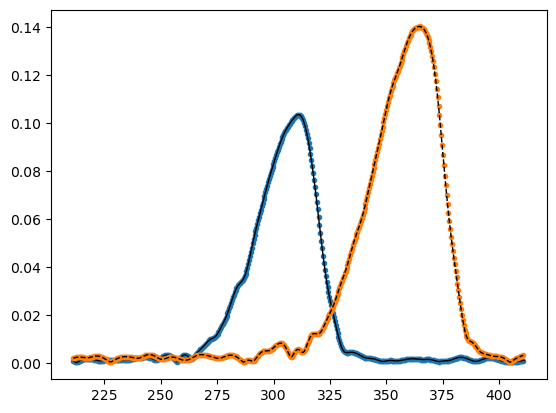

In [4]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# ---------- FFT (zero-padding) ----------
def single_sided_fft(t, y, min_freq_hz=0.0, n_fft=None):
    t = np.asarray(t, float).ravel()
    y = np.asarray(y, float).ravel()
    finite = np.isfinite(t) & np.isfinite(y)
    t, y = t[finite], y[finite]
    if t.size < 2:
        raise ValueError("Not enough samples for FFT.")
    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Invalid time vector spacing.")
    N = y.size
    if n_fft is None:
        n_fft = N
    elif n_fft < N:
        raise ValueError("n_fft must be >= len(y).")

    y = y - np.mean(y)
    w = np.hanning(N)
    cg = w.mean()
    Y = np.fft.rfft(y * w, n=n_fft)
    freqs = np.fft.rfftfreq(n_fft, d=dt)
    amps = (2.0 / (N * cg)) * np.abs(Y)
    if amps.size > 0:
        amps[0] *= 0.5
    if (n_fft % 2 == 0) and (amps.size > 1):
        amps[-1] *= 0.5

    idx_valid = np.where(freqs >= max(min_freq_hz, 0.0))[0]
    if idx_valid.size == 0:
        raise ValueError("No valid frequency bins after min_freq_hz.")
    if freqs[idx_valid[0]] == 0.0 and idx_valid.size > 1:
        idx_valid = idx_valid[1:]
    i_peak = idx_valid[np.argmax(amps[idx_valid])]
    return freqs, amps, float(freqs[i_peak]), float(amps[i_peak])

# ---------- Peak models & helpers ----------
def skewed_gaussian(x, a, x0, sigma, skew, baseline):
    """
    Skewed Gaussian: a * exp(-0.5*z^2) * (1 + erf(skew*z/sqrt(2))) + baseline
    z = (x - x0)/sigma
    """
    z = (x - x0) / (sigma + 1e-20)
    return a * np.exp(-0.5 * z*z) * (1.0 + np.erf(skew * z / np.sqrt(2.0))) + baseline

def parabolic_refine(x, y, i):
    if i <= 0 or i >= len(y)-1:
        return float(x[i]), float(y[i])
    y1, y2, y3 = y[i-1], y[i], y[i+1]
    denom = (y1 - 2*y2 + y3)
    if denom == 0:
        return float(x[i]), float(y2)
    delta = 0.5 * (y1 - y3) / denom     # in bins
    dx = x[1] - x[0]
    x_peak = x[i] + delta * dx
    y_peak = y2 - 0.25 * (y1 - y3) * delta
    return float(x_peak), float(y_peak)

def fit_skewed_peak_window(freqs, amps, f_center, window_size=100.0):
    """
    Fit a skewed Gaussian in [f_center - window, f_center + window].
    Returns: f_fit, (popt, pcov), (fx_fit, ay_fit)
    Falls back to parabolic refine if fit fails.
    """
    m = (freqs >= f_center - window_size) & (freqs <= f_center + window_size)
    fx = freqs[m]
    ay = amps[m]
    if fx.size < 5:
        i = int(np.argmax(amps))
        f_par, _ = parabolic_refine(freqs, amps, i)
        return f_par, (None, None), (fx, ay)

    # initial params
    baseline0 = float(np.median(ay))
    a0 = float(ay.max() - baseline0)
    x0 = float(fx[np.argmax(ay)])
    # rough sigma estimate from half max
    try:
        half = baseline0 + 0.5 * a0
        above = np.where(ay >= half)[0]
        if above.size >= 2:
            sigma0 = 0.5 * (fx[above[-1]] - fx[above[0]]) / np.sqrt(2*np.log(2))
        else:
            sigma0 = max(1.0, window_size/10.0)
    except Exception:
        sigma0 = max(1.0, window_size/10.0)
    skew0 = 0.0

    p0 = [max(a0, 1e-12), x0, max(sigma0, 1e-6), skew0, baseline0]
    lb = [0.0, f_center - 2*window_size, 1e-6, -20.0, -np.inf]
    ub = [np.inf, f_center + 2*window_size, np.inf, 20.0,  np.inf]

    try:
        popt, pcov = curve_fit(skewed_gaussian, fx, ay, p0=p0, bounds=(lb, ub), maxfev=20000)
        f_fit = float(popt[1])
        fx_fit = np.linspace(fx.min(), fx.max(), 1000)
        ay_fit = skewed_gaussian(fx_fit, *popt)
        return f_fit, (popt, pcov), (fx_fit, ay_fit)
    except Exception:
        # fallback to parabolic within window
        i_loc = int(np.argmax(ay))
        f_par, _ = parabolic_refine(fx, ay, i_loc)
        return f_par, (None, None), (fx, ay)

# ---------- Your pipeline (MI anchors SNOM) ----------
# Inputs assumed defined: x_snom_raw, y_snom_raw, x_mi_raw, y_mi_raw, WL, pitch_values, interpolated_dia_values

PAD = 10
MIN_FREQ_HZ = 1.0
WINDOW_HZ = 100.0

# FFTs
freqs_snom, amps_snom, fpk_snom, _ = single_sided_fft(
    x_snom_raw, y_snom_raw, min_freq_hz=MIN_FREQ_HZ, n_fft=PAD*len(y_snom_raw)
)
freqs_mi, amps_mi, fpk_mi, _ = single_sided_fft(
    x_mi_raw, y_mi_raw, min_freq_hz=MIN_FREQ_HZ, n_fft=PAD*len(y_mi_raw)
)

# 1) Fit MI first (anchor)
f_mi_fit, (popt_mi, _), (fx_mi_fit, ay_mi_fit) = fit_skewed_peak_window(
    freqs_mi, amps_mi, f_center=fpk_mi, window_size=WINDOW_HZ
)

# 2) Fit SNOM around the **MI center** (not the SNOM coarse peak)
f_snom_fit, (popt_snom, _), (fx_snom_fit, ay_snom_fit) = fit_skewed_peak_window(
    freqs_snom, amps_snom, f_center=f_mi_fit, window_size=WINDOW_HZ
)

# quick plot
if 1:
    plt.figure()
    m_mi = (freqs_mi >= f_mi_fit - WINDOW_HZ) & (freqs_mi <= f_mi_fit + WINDOW_HZ)
    plt.plot(freqs_mi[m_mi], amps_mi[m_mi], 'o', ms=3, label='MI')
    if fx_mi_fit is not None: plt.plot(fx_mi_fit, ay_mi_fit, '-', lw=1, label='MI skewed-G fit', color='black')

    m_sn = (freqs_snom >= f_mi_fit - WINDOW_HZ) & (freqs_snom <= f_mi_fit + WINDOW_HZ)
    plt.plot(freqs_snom[m_sn], amps_snom[m_sn], 'o', ms=3, label='SNOM')
    if fx_snom_fit is not None: plt.plot(fx_snom_fit, ay_snom_fit, '--', lw=1, label='SNOM skewed-G fit', color='black')

    plt.xlim([f_peak - 40, ctr + 40])
    plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude (a.u.)')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ---------- Pitch & diameter ----------
# Using your formulas; ensure units are consistent for WL and pitch scaling
n_eff_raw = f_snom_fit / f_mi_fit
beta_raw = 2*np.pi*n_eff_raw / WL
pitch_raw = np.pi / beta_raw * 1e-3   # keep your original scaling (adjust if needed)

# Optionally still report coarse peak ratio:
n_eff_coarse = fpk_snom / fpk_mi
beta_c = 2*np.pi*n_eff_coarse / WL
pitch_c = np.pi / beta_c * 1e-3

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = np.asarray(pitch_values_m, float).ravel()
    dv = np.asarray(dia_vals, float).ravel()
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

dia_fit, _ = nearest_diameter_from_pitch(pitch_raw, pitch_values, interpolated_dia_values)
dia_c,   _ = nearest_diameter_from_pitch(pitch_c,   pitch_values, interpolated_dia_values)

print(f"MI-anchored skewed-G fit frequencies: MI={f_mi_fit:.6f} Hz, SNOM={f_snom_fit:.6f} Hz")
print(f"Diameter (fit): {dia_fit[0]*1e9:.2f} nm   |   Diameter (coarse): {dia_c[0]*1e9:.2f} nm")


#### 100 simulations

In [7]:
len(mz_mi_sim)

2

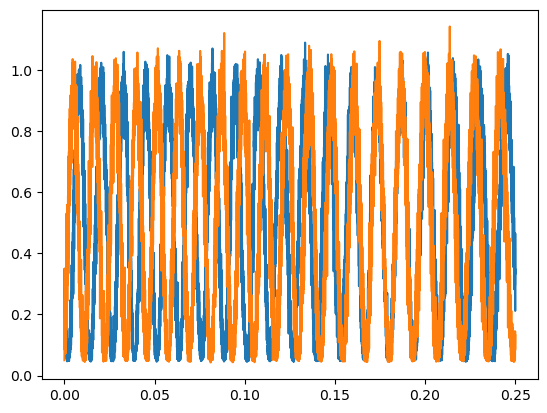

In [10]:
from mz_nonlinear_reconstruction import MZSimulator
import numpy as np
import matplotlib.pyplot as plt

# for generating nonlinear SNOM signal
MZ_sim = MZSimulator()
MZ_sim.t_end = 0.25
MZ_sim.n_points = 10000
MZ_sim.nonlinearity_strength = 10
N_SNOM = 20
N_MI = 19
WL = 1389 # nm

MZ_sim.phase_noise_std = np.random.uniform(0.18, 0.23)
MZ_sim.amplitude_noise_std = np.random.uniform(0.04,0.06)
MZ_sim.n_fringes = N_SNOM

# generating SNOM signal (no-amp modulation)
# t_snom_sim, z_snom_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
t_snom_sim, mz_snom_sim = MZ_sim.generate_signal(nonlin_type='cubic')

# Generation MI signal
MZ_sim.amplitude_noise_std = MZ_sim.amplitude_noise_std - 0.01
MZ_sim.phase_noise_std = MZ_sim.phase_noise_std - 0.05

MZ_sim.n_fringes = N_MI
# t_mi_sim, z_mi_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
t_mi_sim, mz_mi_sim = MZ_sim.generate_signal(nonlin_type='cubic')

plt.figure()
plt.plot(t_mi_sim, mz_mi_sim )
plt.plot(t_snom_sim,mz_snom_sim )

In [3]:
dia_calc_3

[900.069297862287,
 nan,
 899.6257517486883,
 nan,
 900.2171990352549,
 900.069297862287,
 900.069297862287,
 nan,
 nan,
 900.2171990352549]

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

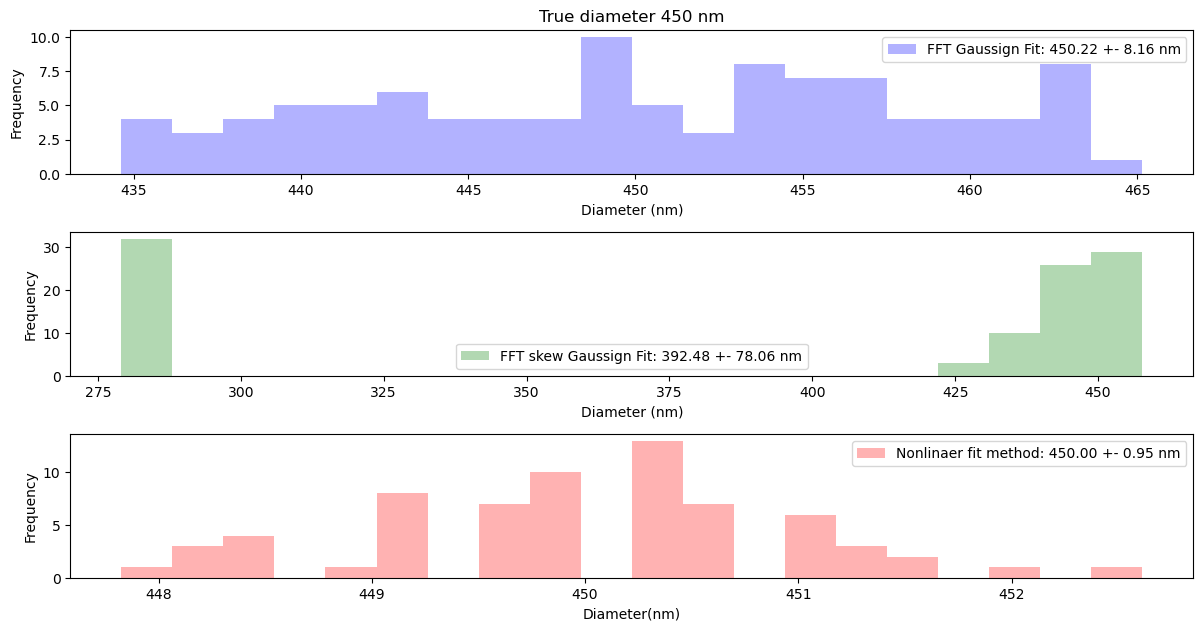

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

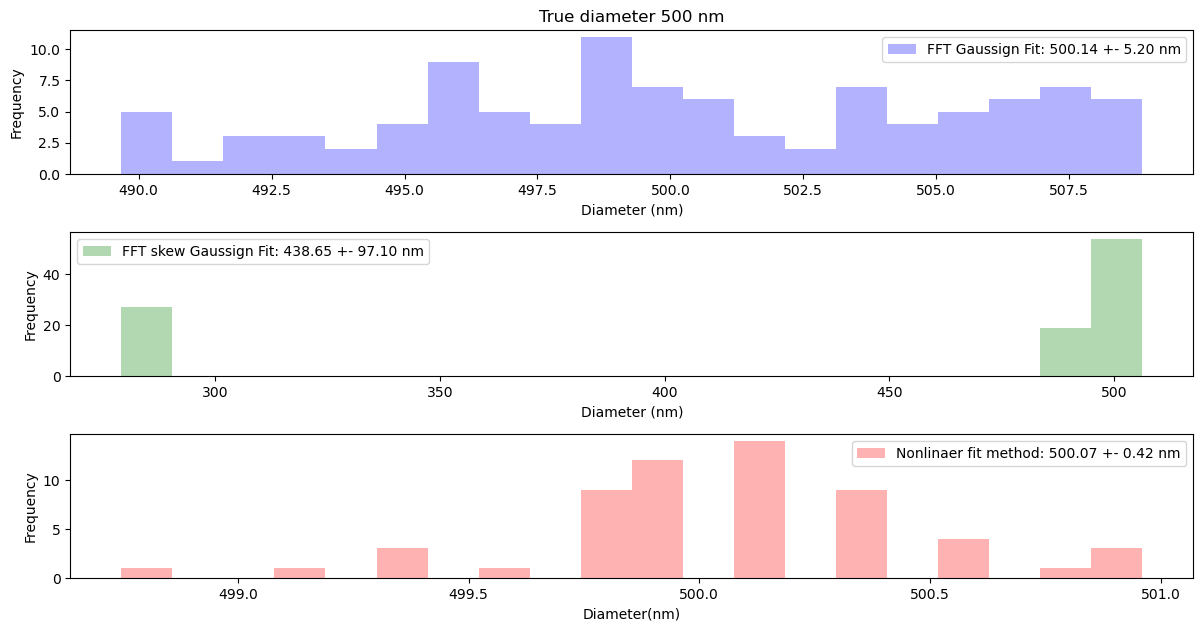

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

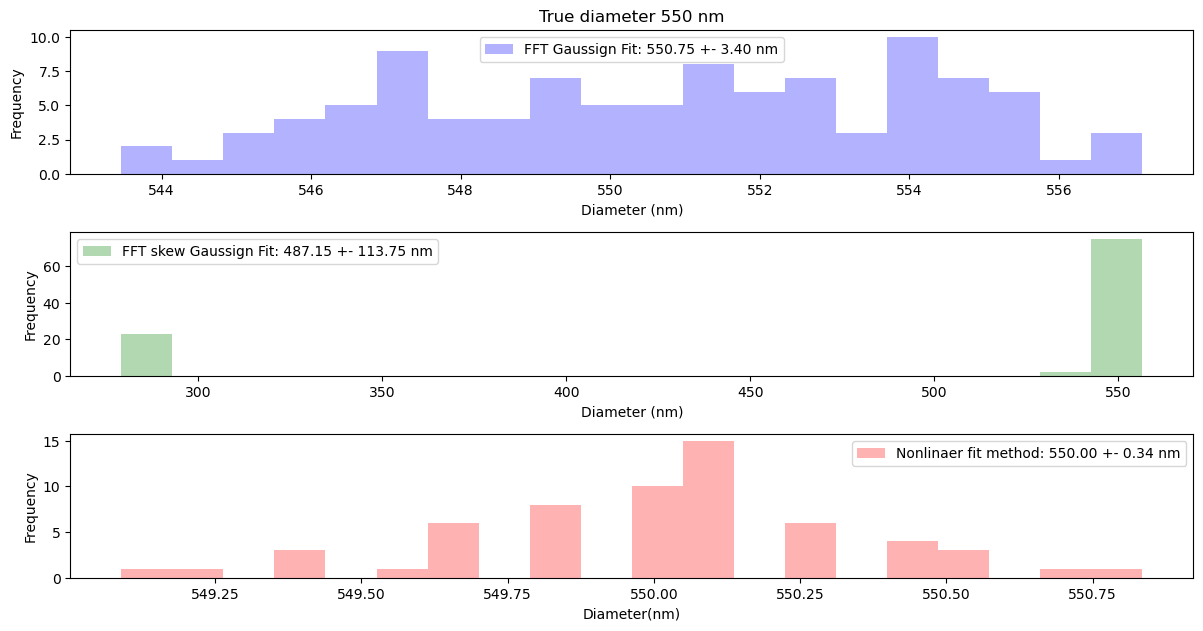

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

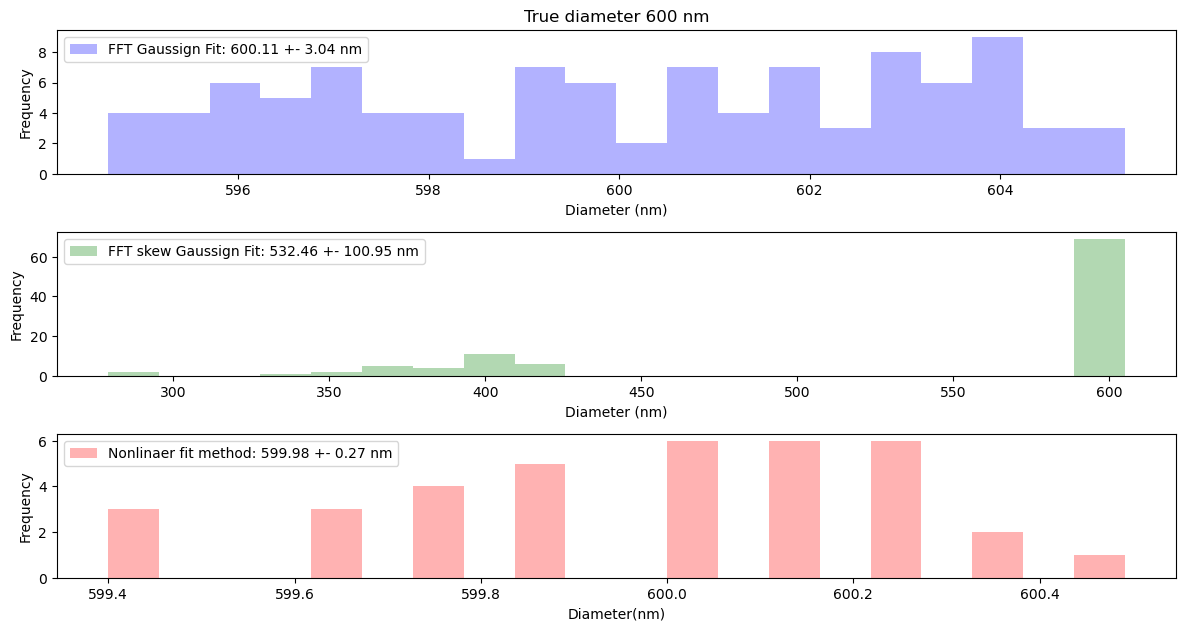

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

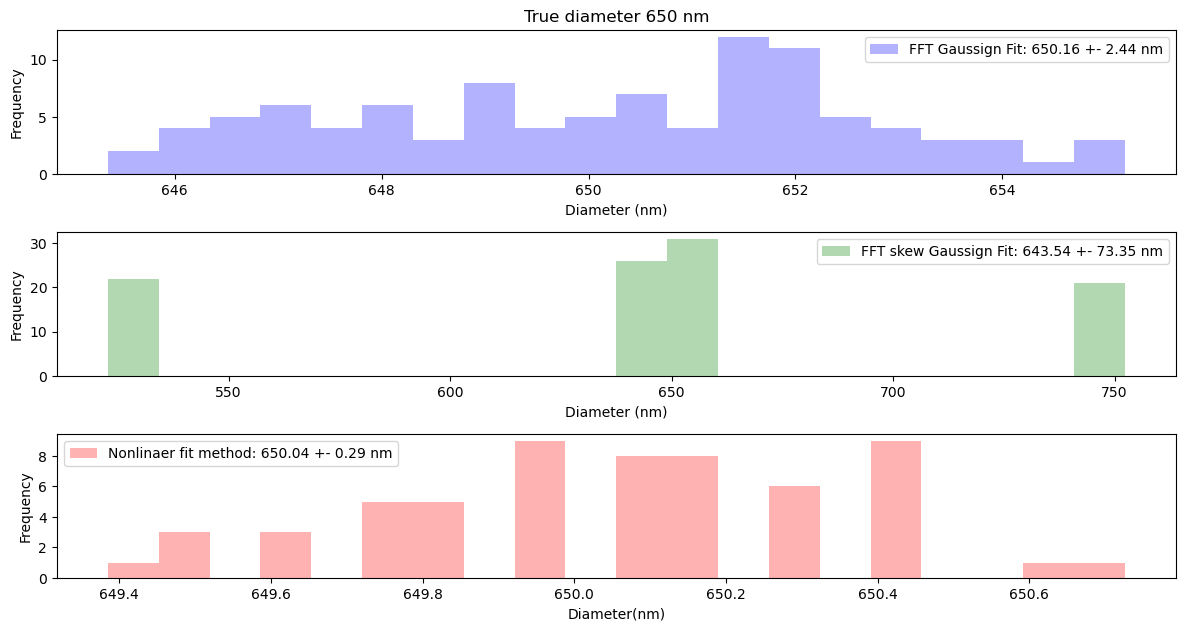

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

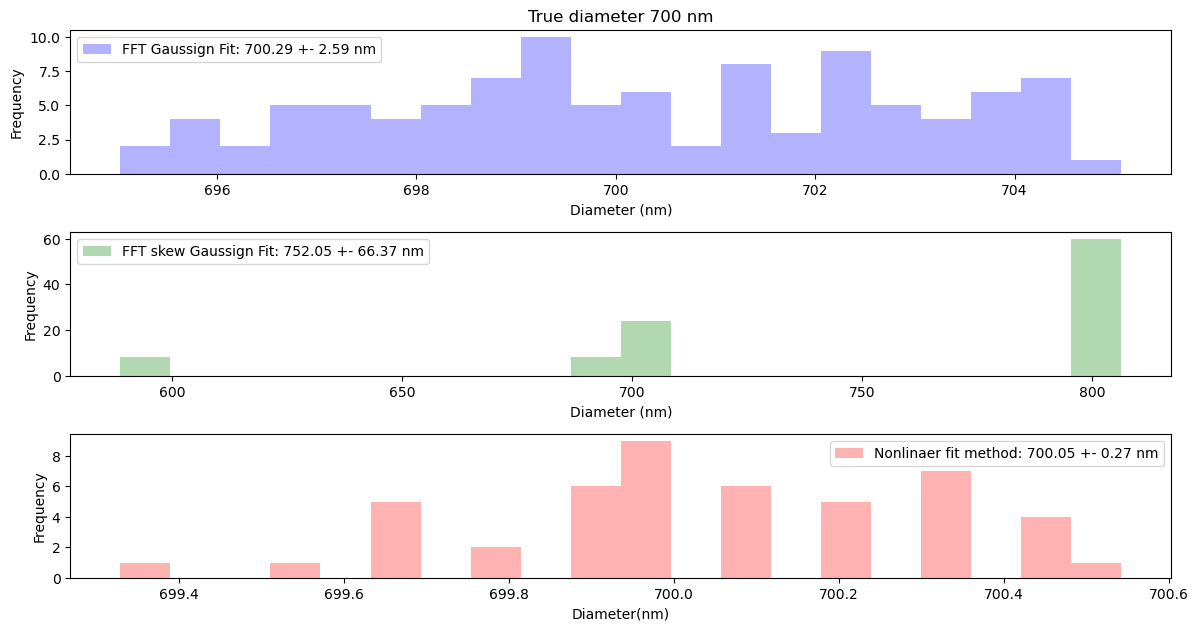

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

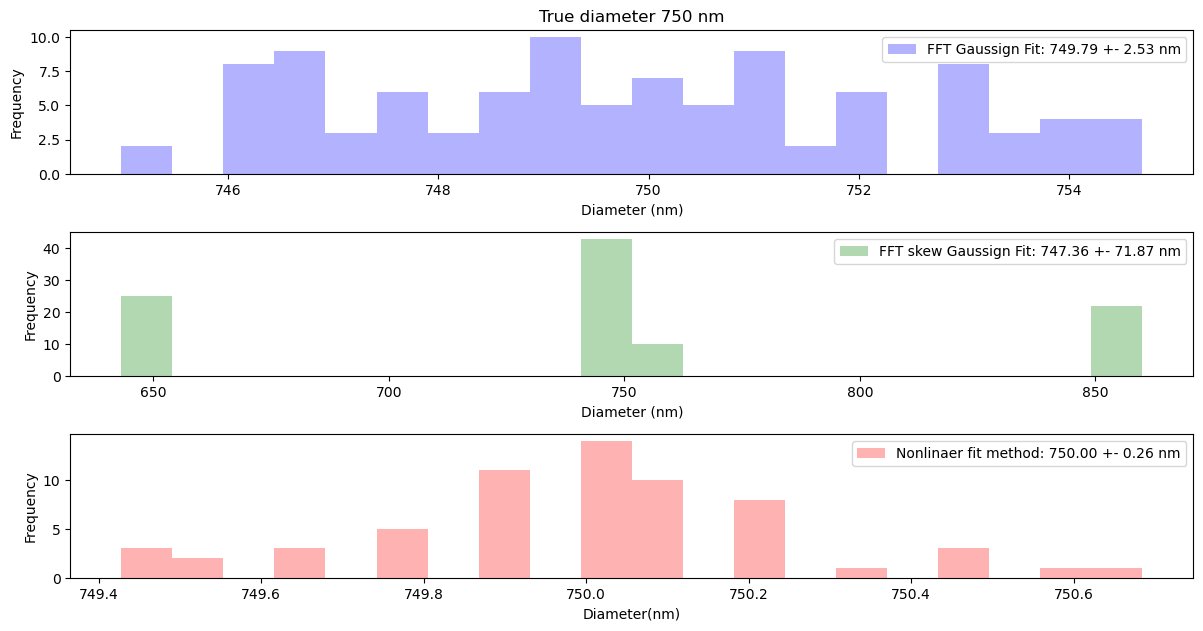

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

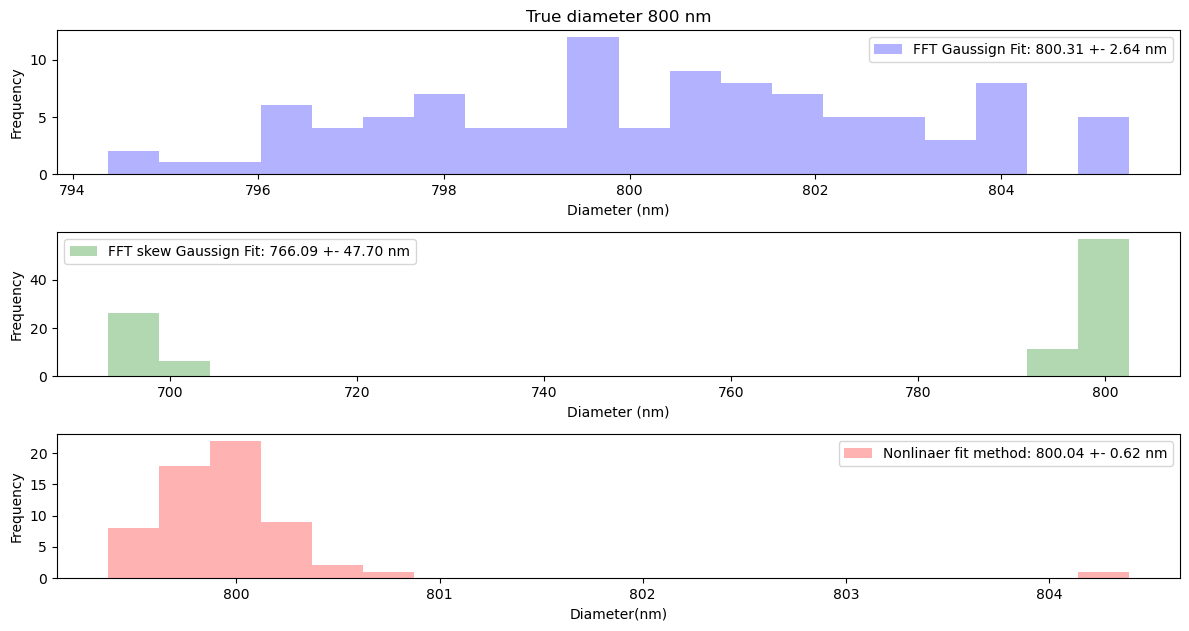

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

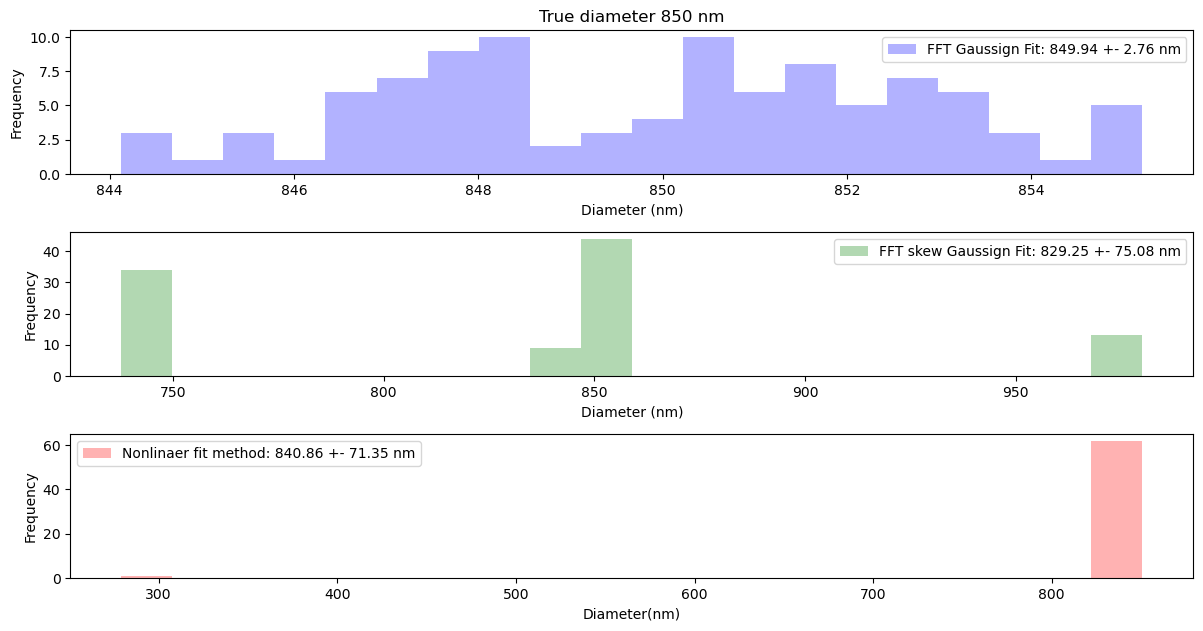

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)(0)
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________

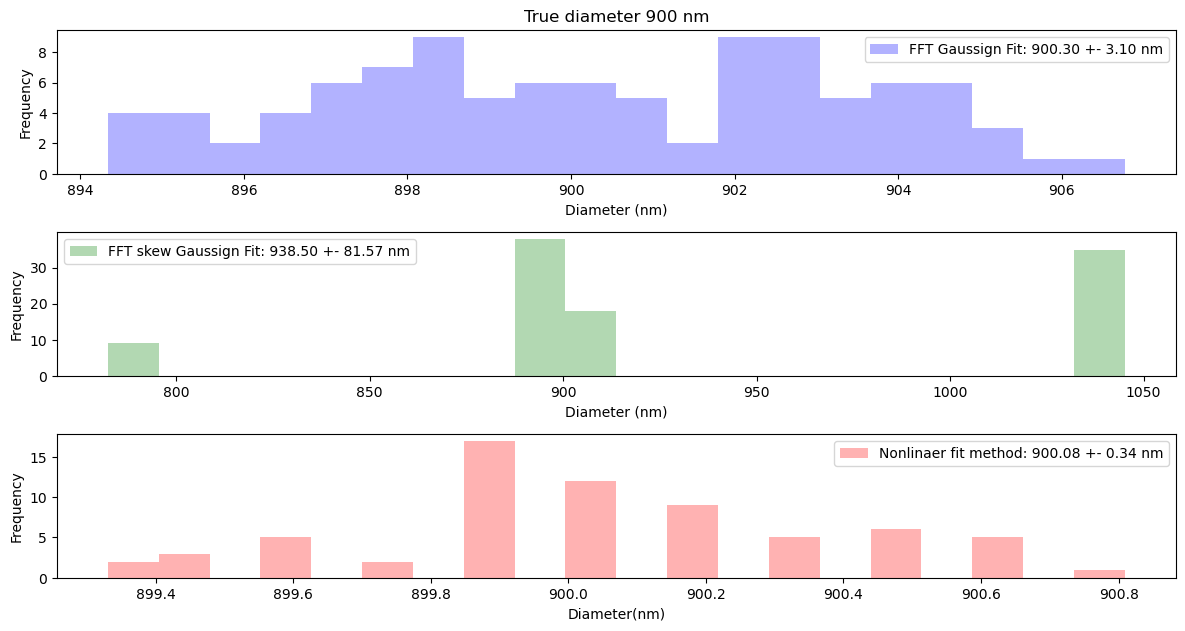

In [1]:
from mz_nonlinear_reconstruction import MZSimulator
from mz_nonlinear_reconstruction import ZReconstructor
from mz_nonlinear_reconstruction import evaluate_methods
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

filename = "./data/0_.npy"
analysis = DataAnalysis(filename, N = 10)

# === Load calibration file ===
data = np.load("./pitches_and_diameters_1389.npz")
pitch_values = data["pitches_1389"]
interpolated_dia_values = data["diameters_1389"]

def gaussian_envelope(x, A=1.0, mu=None, sigma=None, baseline=0):
    x = np.asarray(x, float)
    if mu is None:    mu = 0.5 * (x.min() + x.max())
    if sigma is None: sigma = 0.2 * (x.max() - x.min())  # ~20% of span
    return baseline + A * np.exp(-0.5 * ((x - mu) / (sigma + 1e-12))**2)

def nearest_pitch_from_diameter(dia_m, dia_vals, pitch_values):
    """
    Convert diameter to pitch. 
    """
    dia_m = np.asarray(dia_m, float).ravel()
    pv = pitch_values.ravel()*1e3
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(dia_m[:, None] - dv[None, :]).argmin(axis=1)
    return pv[idx], idx

# for generating nonlinear SNOM signal
MZ_sim = MZSimulator()
MZ_sim.t_end = 0.25
MZ_sim.n_points = 10000
MZ_sim.nonlinearity_strength = 10*2
N_SNOM = 20

WL = 1389 # nm
dia_list = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900] # nm

dia_mean1 = []
dia_sd1 = []

dia_mean2 = []
dia_sd2 = []

dia_mean3 = []
dia_sd3 = []

dia_mean4 = []
dia_sd4 = []

for i in range(len(dia_list)):

    dia = dia_list[i]*1e-9

    dia_calc_1 = []
    dia_calc_2 = []
    dia_calc_3 = []
    dia_calc_4 = []


    # parameter settings
    pitch, idx = nearest_pitch_from_diameter(dia, interpolated_dia_values, pitch_values) # nm
    beta = np.pi/pitch
    n_eff = beta*WL/(2*np.pi)
    N_MI = N_SNOM/n_eff

    for j in range(100):
            MZ_sim.phase_noise_std = np.random.uniform(0.18, 0.23)
            MZ_sim.amplitude_noise_std = np.random.uniform(0.04,0.06)
            MZ_sim.n_fringes = N_SNOM

            # generating SNOM signal (no-amp modulation)
            # t_sim, z_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
            t_sim, mz_sim = MZ_sim.generate_signal(nonlin_type='cubic')

            # Generation MI signal
            MZ_sim.amplitude_noise_std = MZ_sim.amplitude_noise_std - 0.01
            MZ_sim.phase_noise_std = MZ_sim.phase_noise_std - 0.05

            MZ_sim.n_fringes = N_MI
            # t_mi_sim, z_mi_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
            t_mi_sim, mz_mi_sim = MZ_sim.generate_signal(nonlin_type='cubic')
        

            # Gaussian envelop
            A    = np.random.uniform(0.5, 1.0)          # envelope depth
            mu   = np.random.uniform(t_sim.min(), t_sim.max())
            sigma= 1.5 * np.random.uniform(t_sim.max() - t_sim.min(), t_sim.max() - t_sim.min())   # envelope width
            env  = gaussian_envelope(t_sim, A=A, mu=mu, sigma=sigma, baseline=0)



            x_snom_raw = t_sim
            y_snom_raw = env * (mz_sim-0.45)  # Gaussian-modulated SNOM signal
            y_snom_raw = (y_snom_raw - np.min(y_snom_raw)) / (np.max(y_snom_raw) - np.min(y_snom_raw))

            x_mi_raw = t_mi_sim
            y_mi_raw = mz_mi_sim

            print('________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________')
            print(f'({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})({j})')
            print('________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________')


            dia_11 = analysis.FFT_with_Gaussian_fit(x_mi_raw,y_mi_raw,x_snom_raw,y_snom_raw)
            print('------------------------------------------------------------------------------------------')
            dia_22 = analysis.FFT_with_skewed_Gaussian_fit(x_mi_raw,y_mi_raw,x_snom_raw,y_snom_raw)
            print('------------------------------------------------------------------------------------------')
            dia_33 = analysis.nonlinear_method_diameter(x_mi_raw,y_mi_raw,x_snom_raw,y_snom_raw, 0)
            print('------------------------------------------------------------------------------------------')
            # dia_44 = analysis.zero_crossing_interpol_method_diameter(x_mi_raw,y_mi_raw,y_snom_raw,0)

            dia_calc_1.append(dia_11[0][0]*1e9)
            dia_calc_2.append(dia_22[0]*1e9)
            if not np.isnan(dia_33[0]):
                dia_calc_3.append(dia_33[0] * 1e9)   
            # dia_calc_4.append(dia_44[0]*1e9)

    dia_mean1_ = np.mean(dia_calc_1, axis=0)
    dia_sd1_ = np.std(dia_calc_1, axis=0)

    dia_mean2_ = np.mean(dia_calc_2, axis=0)
    dia_sd2_ = np.std(dia_calc_2, axis=0)

    dia_mean3_ = np.mean(dia_calc_3, axis=0)
    dia_sd3_ = np.std(dia_calc_3, axis=0)

    # dia_mean4_ = np.mean(dia_calc_4, axis=0)
    # dia_sd4_ = np.std(dia_calc_4, axis=0)

    dia_mean1.append(dia_mean1_)
    dia_sd1.append(dia_sd1_)

    dia_mean2.append(dia_mean2_)
    dia_sd2.append(dia_sd2_)

    dia_mean3.append(dia_mean3_)
    dia_sd3.append(dia_sd3_)

    # dia_mean4.append(dia_mean4_)
    # dia_sd4.append(dia_sd4_)

    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.hist(dia_calc_1, bins=20, alpha=0.3, color='blue', label=f'FFT Gaussign Fit: {dia_mean1_:.2f} +- {dia_sd1_:.2f} nm')
    plt.title(f'True diameter {dia_list[i]} nm')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Frequency')
    
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.hist(dia_calc_2, bins=20, alpha=0.3, color='green', label=f'FFT skew Gaussign Fit: {dia_mean2_:.2f} +- {dia_sd2_:.2f} nm')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.hist(dia_calc_3, bins=20, alpha=0.3, color='red', label=f'Nonlinaer fit method: {dia_mean3_:.2f} +- {dia_sd3_:.2f} nm')
    plt.xlabel('Diameter(nm)')
    plt.ylabel('Frequency')
    plt.legend()

    # plt.subplot(4, 1, 4)
    # plt.hist(dia_calc_4, bins=20, alpha=0.3, color='black', label='Zero crossing method')
    # plt.xlabel('Diameter')
    # plt.ylabel('Frequency')
    # plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from mz_nonlinear_reconstruction import MZSimulator
from mz_nonlinear_reconstruction import ZReconstructor
from mz_nonlinear_reconstruction import evaluate_methods
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

filename = "./data/0_.npy"

# for generating nonlinear MI signal
MZ_sim = MZSimulator()
MZ_sim.n_fringes = 20
MZ_sim.nonlinearity_strength = 10
MZ_sim.n_points = 10000
MZ_sim.t_end = 0.25

WL = 1389 # nm
dia = 600*1e-9 # m

# Load pitch diameter profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

def nearest_pitch_from_diameter(dia_m, dia_vals, pitch_values):
    """
    Convert diameter to pitch. 
    """
    dia_m = np.asarray(dia_m, float).ravel()
    pv = pitch_values.ravel()*1e3
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(dia_m[:, None] - dv[None, :]).argmin(axis=1)
    return pv[idx], idx

# parameter settings
pitch, idx = nearest_pitch_from_diameter(dia, interpolated_dia_values, pitch_values) # nm
beta = np.pi/pitch
n_eff = beta*WL/(2*np.pi)
N_MI = MZ_sim.n_fringes/n_eff

# generating SNOM signal (no-amp modulation)
t_sim, z_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_sim = MZ_sim.generate_mz_signal(z_sim)

sampling_points = 1000
transformer = ZReconstructor(mz_sim, sampling_points)

# method 2
mz_transform_ = transformer.method2_hilbert_transform()
mz_trans__sim = MZ_sim.generate_mz_signal(mz_transform_)


# Evaluate the method accuracy
method_name = 'method2_hilbert_transform'
evaluate_methods(z_sim,mz_transform_, method_name)

# Generation MI signal
MZ_sim.n_fringes = N_MI
t_mi_sim, z_mi_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_mi_sim = MZ_sim.generate_mz_signal(z_mi_sim)

sampling_points = 1000
transformer_mi = ZReconstructor(mz_mi_sim, sampling_points)

# method 2
mz_transform_mi = transformer.method2_hilbert_transform()
mz_trans__mi_sim = MZ_sim.generate_mz_signal(mz_transform_mi)

# important variables
x_snom_raw = t_sim
y_snom_raw = mz_sim

x_snom_trans = t_sim
y_snom_trans = mz_trans__sim

x_mi_raw = t_mi_sim
y_mi_raw = mz_mi_sim

x_mi_trans = t_mi_sim
y_mi_trans = mz_trans__mi_sim


In [ ]:
from mz_nonlinear_reconstruction import MZSimulator
from mz_nonlinear_reconstruction import ZReconstructor
from mz_nonlinear_reconstruction import evaluate_methods
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

filename = "./data/0_.npy"

# for generating nonlinear MI signal
MZ_sim = MZSimulator()
MZ_sim.n_fringes = 20
MZ_sim.nonlinearity_strength = 10
MZ_sim.n_points = 10000
MZ_sim.t_end = 0.25

WL = 1389 # nm
dia = 600*1e-9 # m

# Load pitch diameter profile
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

def nearest_pitch_from_diameter(dia_m, dia_vals, pitch_values):
    """
    Convert diameter to pitch. 
    """
    dia_m = np.asarray(dia_m, float).ravel()
    pv = pitch_values.ravel()*1e3
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(dia_m[:, None] - dv[None, :]).argmin(axis=1)
    return pv[idx], idx

# parameter settings
pitch, idx = nearest_pitch_from_diameter(dia, interpolated_dia_values, pitch_values) # nm
beta = np.pi/pitch
n_eff = beta*WL/(2*np.pi)
N_MI = MZ_sim.n_fringes/n_eff

# generating SNOM signal (no-amp modulation)
t_sim, z_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_sim = MZ_sim.generate_mz_signal(z_sim)

sampling_points = 1000
transformer = ZReconstructor(mz_sim, sampling_points)

# method 2
mz_transform_ = transformer.method2_hilbert_transform()
mz_trans__sim = MZ_sim.generate_mz_signal(mz_transform_)


# Evaluate the method accuracy
method_name = 'method2_hilbert_transform'
evaluate_methods(z_sim,mz_transform_, method_name)

# Generation MI signal
MZ_sim.n_fringes = N_MI
t_mi_sim, z_mi_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic')
mz_mi_sim = MZ_sim.generate_mz_signal(z_mi_sim)

sampling_points = 1000
transformer_mi = ZReconstructor(mz_mi_sim, sampling_points)

# method 2
mz_transform_mi = transformer.method2_hilbert_transform()
mz_trans__mi_sim = MZ_sim.generate_mz_signal(mz_transform_mi)

# important variables
x_snom_raw = t_sim
y_snom_raw = mz_sim

x_snom_trans = t_sim
y_snom_trans = mz_trans__sim

x_mi_raw = t_mi_sim
y_mi_raw = mz_mi_sim

x_mi_trans = t_mi_sim
y_mi_trans = mz_trans__mi_sim


In [4]:
print(dia_mean1)
print(dia_sd1)

print(dia_mean2)
print(dia_sd2)



[450.08679475768776, 500.1423313071541, 550.1282472764219, 600.4311328077384, 650.5265400500851, 700.0594856002799, 750.6768938399124, 800.2933135046724, 849.9990308685832, 899.2795337874222]
[9.302860895558242, 5.615628351839719, 3.798922390200946, 3.354591910615476, 3.0005542547549835, 2.735877504307251, 3.0231269566512435, 2.885124414962391, 3.5711705103996336, 3.432573175530349]
[445.4761084628301, 498.07239433343415, 548.3602898183167, 598.9105059991429, 649.3984136290655, 699.3437936603483, 749.5768424982547, 799.6242964238122, 849.5310507017555, 898.8199626523847]
[10.538071636558898, 5.05237369470273, 3.5754472934971266, 3.3921443310012425, 2.7964459198576423, 2.8495846624993266, 2.729617074448009, 2.7620501681011933, 3.2434785159691413, 3.1150004493914834]


### Nonlinear phase fitting with simulated data

In [ ]:
from mz_nonlinear_reconstruction import MZSimulator
from mz_nonlinear_reconstruction import ZReconstructor
from mz_nonlinear_reconstruction import evaluate_methods
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

filename = "./data/0_.npy"
analysis = DataAnalysis(filename, N=10)

# for generating nonlinear MI signal
MZ_sim = MZSimulator()
MZ_sim.n_fringes = 8
MZ_sim.nonlinearity_strength = 4
MZ_sim.n_points = 10000
MZ_sim.t_end = 0.25


# generating nonlinear signal (no-amp modulation)
t_sim, z_sim = MZ_sim.generate_nonlinear_scan(nonlin_type='cubic') # phase
mz_sim = MZ_sim.generate_mz_signal(z_sim) # sine signal

# nonlinear fit to 
x, y = analysis.nonlinear_method_sim(t_sim, mz_sim)

# plot the fitting result
plt.figure()
plt.plot(t_sim, mz_sim, '.')
plt.plot(x,y,'-', color='black', lw = 1)

In [ ]:
import numpy as np
from scipy.signal import hilbert

# method 2
sampling_points = 1000
transformer = ZReconstructor(y, sampling_points)
transformer_ =  ZReconstructor(mz_sim, sampling_points)
mz_transform_ = transformer.method2_hilbert_transform()
z_sim_inverse = transformer_.method2_hilbert_transform()
# z_nonlin_fit = MZ_sim.generate_mz_signal(mz_transform_) # sine signal after transform

mz_unwrap = np.mod(mz_transform_, 2*np.pi)
plt.figure()
plt.plot(x, mz_unwrap + 10,label='phase from fit, remove factor 2')
plt.plot(t_sim, np.mod(z_sim, 2*np.pi), label='phase from simulation')
plt.legend()

### Somehting else


In [ ]:
from Data_analysis import DataAnalysis
import numpy as np
import matplotlib.pyplot as plt

## The whole axial scans
# stage_pos = [-600, -400, -200, 0, 200, 400, 600]
stage_pos = [0]

fiber_dia1_ = []
fiber_dia2_ = []
fiber_dia3_ = []

dia_err1_ = []
dia_err2_ = []
dia_err3_ = []

pitch_1_ = []
pitch_2_ = []
pitch_3_ = []

pitch_err1_ = []
pitch_err2_ = []
pitch_err3_ = []


for i in range(len(stage_pos)):
    if stage_pos[i] < 0:
        filename = f'./data/m{abs(stage_pos[i])}_.npy'
    if stage_pos[i] >= 0:
        filename = f'./data/{abs(stage_pos[i])}_.npy'

    beta1_array = []
    beta1_err_array = []

    beta2_array = []
    beta2_err_array = []

    beta3_array = []
    beta3_err_array = []

    for N in range(10,50):
        analysis = DataAnalysis(filename, N)
        analysis.linear_method()
        if hasattr(analysis, 'x_linear'):
            xx1, yy1, beta1, beta1_err = analysis.EnvSin_fit(1,0) # for linear fit, polynomial envelop is better
            beta1_array.append(beta1)
            beta1_err_array.append(beta1_err)

        # nonlinear method
        analysis.nonlinear_method()
        xx2, yy2, beta2, beta2_err = analysis.EnvSin_fit(0,1)
        beta2_array.append(beta2)
        beta2_err_array.append(beta2_err)

        # linear iterpolate method
        beta3 = analysis.zero_crossing_interpol()
        beta3_array.append(beta3)
    
    # remove None in the lists
    beta1_array = [b for b in beta1_array if b is not None]
    beta2_array = [b for b in beta2_array if b is not None]

    beta1_error_array = [b for b in beta1_err_array if b is not None]
    beta2_error_array = [b for b in beta2_err_array if b is not None]

    # Calculate weighted mean and SME
    Mw1, SMEw1 = analysis.weighted_cal(beta1_array, beta1_error_array)
    Mw2, SMEw2 = analysis.weighted_cal(beta2_array, beta2_error_array)
    M3, sd3 = np.mean(beta3_array), np.std(beta3_array)

    # Convert them into pitch
    pitch1 = np.pi/Mw1*1e-6 # m
    pitch1_err = np.pi/Mw1**2*SMEw1*1e-6 # m
    pitch_1_.append(pitch1)
    pitch_err1_.append(pitch1_err)

    pitch2 = np.pi/Mw2*1e-6 # m
    pitch2_err = np.pi/Mw2**2*SMEw2*1e-6 # m
    pitch_2_.append(pitch2)
    pitch_err2_.append(pitch2_err)

    pitch3 = np.pi/M3*1e-6 # m
    pitch3_err = np.pi/M3**2*sd3*1e-6 # m
    pitch_3_.append(pitch3)
    pitch_err3_.append(pitch3_err)

    # diameter calculation
    d1, d1_err = analysis.diamter_calculation(pitch1, pitch1_err)
    fiber_dia1_.append(d1)
    dia_err1_.append(d1_err)
    

    d2, d2_err = analysis.diamter_calculation(pitch2, pitch2_err)
    fiber_dia2_.append(d2)
    dia_err2_.append(d2_err)

    d3, d3_err = analysis.diamter_calculation(pitch3, pitch3_err)
    fiber_dia3_.append(d3)
    dia_err3_.append(d3_err)


In [ ]:
# Plot the result
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot pitch on the left y-axis
ax1.set_xlabel('Stage Position')
ax1.set_ylabel('Pitch (m)', color='tab:blue')
ax1.errorbar(stage_pos, pitch_1_, yerr=pitch_err1_, label='Pitch 1', fmt='-o', color='tab:blue')
ax1.errorbar(stage_pos, pitch_2_, yerr=pitch_err2_, label='Pitch 2', fmt='-s', color='tab:cyan')
ax1.errorbar(stage_pos, pitch_3_, yerr=pitch_err3_, label='Pitch 3', fmt='-^', color='tab:purple')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin Axes sharing the x-axis for the fiber diameters
ax2 = ax1.twinx()
ax2.set_ylabel('Fiber Diameter (m)', color='tab:red')
ax2.errorbar(stage_pos, fiber_dia1_, yerr=dia_err1_, label='Fiber Dia 1', fmt='-o', color='tab:red')
ax2.errorbar(stage_pos, fiber_dia2_, yerr=dia_err2_, label='Fiber Dia 2', fmt='-s', color='tab:orange')
ax2.errorbar(stage_pos, fiber_dia3_, yerr=dia_err3_, label='Fiber Dia 3', fmt='-^', color='tab:pink')
ax2.tick_params(axis='y', labelcolor='tab:red')



# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Fiber Pitch and Diameter vs Stage Position')
plt.show()



In [ ]:
from Data_analysis import DataAnalysis

filename = "./data/m600_.npy"
N = 10
# beta2_array = []
# for N in range(10,50):
analysis = DataAnalysis(filename, N)
analysis.nonlinear_method()
xx2, yy2, beta2 = analysis.EnvSin_fit(0,1)
    # beta2_array.append(beta2)

In [ ]:
from Data_analysis import DataAnalysis

filename = "./data/0_.npy"
N = 10
# beta2_array = []
# for N in range(10,50):
analysis = DataAnalysis(filename, N)
beta3 = analysis.zero_crossing_interpol()

print(beta)


In [ ]:
from Data_analysis import DataAnalysis

filename = "./data/0_.npy"

analysis = DataAnalysis(filename, 10)
analysis.linear_method()
if hasattr(analysis, 'x_linear'):
    xx1, yy1, beta1, beta1_err = analysis.EnvSin_fit(1,0) # for linear fit, polynomial envelop is better


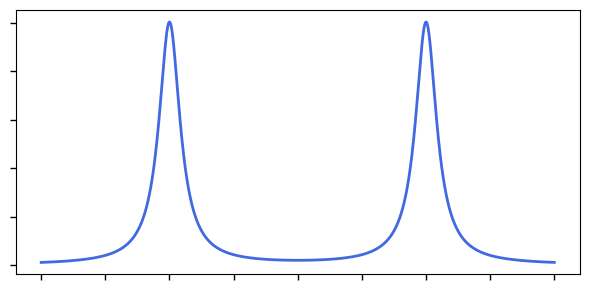

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def lorentzian(x, x0, gamma, amplitude=1.0):
    return amplitude * ((gamma/2)**2 / ((x - x0)**2 + (gamma/2)**2))

def double_lorentzian(x, x0, gamma, split, amp1=1.0, amp2=1.0):
    x1 = x0 - split / 2
    x2 = x0 + split / 2
    return lorentzian(x, x1, gamma, amp1) + lorentzian(x, x2, gamma, amp2)

# Parameters
x0, gamma, split = 0.0, 1.0, 10.0
amp1, amp2 = 1.0, 1.0

x = np.linspace(-10, 10, 2000)
y = double_lorentzian(x, x0, gamma, split, amp1, amp2)

# Plot
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y, color='royalblue', linewidth=2)

# Keep axes but remove labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Keep ticks visible
ax.tick_params(axis='both', length=4, width=1)

# Frame and layout
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
# ax.set_title("Lorentzian Doublet", fontsize=12)
plt.tight_layout()
plt.show()
